In [1]:
########### Self-customized setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import math
from numba import jit, float64
from collections import Counter
import igraph as ig
import leidenalg as la
from igraph import Graph, Plot
from igraph.drawing.text import TextDrawer
import cairo
from matplotlib import rcParams

#%% Plot Tong's default setting
SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

rcParams['font.family'] = 'arial'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rcParams["font.weight"] = "bold"
#plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "regular"
plt.rcParams["axes.labelweight"] = "regular"
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 2


In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("Thai_data.pickle","rb")
thai_metagenome_ID, thai_metagenome, thai_metabolome_ID, thai_metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = thai_metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

thai_metagenome_ID_reduced = df_microbes.loc[thai_metagenome_ID].values.flatten()
thai_metagenome_ID = thai_metagenome_ID_reduced[~np.isnan(thai_metagenome_ID_reduced)].astype(int)

thai_metabolome_ID_reduced = df_metabolites.loc[thai_metabolome_ID].values.flatten()
thai_metabolome_ID = thai_metabolome_ID_reduced[~np.isnan(thai_metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
df_metabolites_reversed = df_metabolites.reset_index().set_index('newID')
df_microbes_reversed = df_microbes.reset_index().set_index('newID')
MAX_ID_metabolites = len(df_metabolites)
MAX_ID_microbes = len(df_microbes)

In [5]:
## Corrections for metabolite and microbial IDs when there is an error happens to them
'''
for i in range(0, 100):
    for j in range(len(df[i])):
        max_links = MAX_ID_metabolites * MAX_ID_microbes
        pos_x = df[i]['position in x'].iloc[j]
        edgeType = 2 + int(pos_x >= max_links)
        pos_x = pos_x - (edgeType - 2) * max_links
        row = pos_x // NumMicrobes
        col = pos_x - row * NumMicrobes

        metID = df_metabolites_reversed.loc[row].values[0]
        microbeID = df_microbes_reversed.loc[col].values[0]
        metName = names.loc[metID].values[0]
        microbeName = names.loc[microbeID].values[0]

        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]
        
for i in range(1, 101):
    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')
    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')
    
'''


"\nfor i in range(0, 100):\n    for j in range(len(df[i])):\n        max_links = MAX_ID_metabolites * MAX_ID_microbes\n        pos_x = df[i]['position in x'].iloc[j]\n        edgeType = 2 + int(pos_x >= max_links)\n        pos_x = pos_x - (edgeType - 2) * max_links\n        row = pos_x // NumMicrobes\n        col = pos_x - row * NumMicrobes\n\n        metID = df_metabolites_reversed.loc[row].values[0]\n        microbeID = df_microbes_reversed.loc[col].values[0]\n        metName = names.loc[metID].values[0]\n        microbeName = names.loc[microbeID].values[0]\n\n        df[i].iloc[j, 0:5] = [metID, metName, microbeID, microbeName, edgeType]\n        \nfor i in range(1, 101):\n    df[i-1].to_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv')\n    #df[i-1].to_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv')\n    \n"

In [6]:
df = []
for i in range(1, 101):
    #df.append(pd.read_csv('./data/campusCluster/added_links_full_run'+str(i)+'.csv', index_col=0))
    df.append(pd.read_csv('./data/campusCluster/added_links_prior_distribution_run'+str(i)+'.csv', index_col=0))

In [7]:
df_all = df[0].copy()
for i in range(1, len(df)):
    df_all = pd.concat([df_all, df[i]])
#df_all.set_index('position in x', inplace=True)
df_all.sort_values(['metabolite ID', 'microbes ID'])

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
46,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",123,Bacteroides dorei,3,-0.000398,313,15921
135,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",137,Bacteroides xylanisolvens,2,-0.001000,2266,18
8,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",159,Bilophila wadsworthia,3,0.001676,52,15937
17,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",161,Blautia hansenii (Ruminococcus hansenii),3,0.000610,213,15938
86,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",455,Eubacterium hallii,3,-0.000196,891,15951
106,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",457,Eubacterium rectale,3,0.000108,1718,15953
119,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",512,Haemophilus influenzae,3,-0.001000,2100,15958
120,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",513,Haemophilus parainfluenzae,3,-0.001000,1787,15959
21,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",870,Prevotella copri,3,0.002293,138,15967
147,2001,"[R,R]-2,3-Butanediol ([R,R]-Butanediol, [S,S]-...",895,Pseudoflavonifractor capillosus,2,-0.001000,1961,58


In [8]:
links_added = []
for i in range(len(df)):
    links_added.append(set(df[i]['position in x'].values))

## optimization trajectories

Text(0, 0.5, 'error')

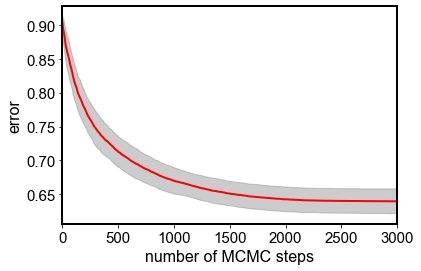

In [9]:
error_all = []
for i in range(len(df)):
    error_list = np.ones((10000)) * 0.9062371391507545
    error_reduction_list = df[i]['error reduced']
    steps_list = df[i]['step added']
    for step, error_reduction in zip(steps_list, error_reduction_list):
        error_list[step:] = error_list[step:] - error_reduction
    error_all.append(error_list)

mean_error = np.mean(np.array(error_all), 0)
std_error = np.std(np.array(error_all), 0)

fig, ax = plt.subplots(1, 1, sharex=True)
ax.plot(np.arange((10000)), mean_error, color='red', lw=2)
ax.fill_between(np.arange((10000)), mean_error-std_error, mean_error+std_error, alpha=0.4, color='grey')
ax.set_xlim([0, 3000])
ax.set_xlabel('number of MCMC steps', fontsize=16)
ax.set_ylabel('error', fontsize=16)
#fig.savefig('./figures/fig1D.svg')

121.73 17.61752252730219


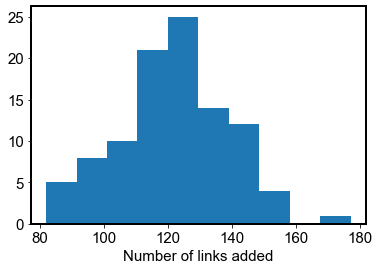

In [10]:
numLinksAdded = list(map(len, links_added))
plt.figure()
plt.hist(numLinksAdded);
plt.xlabel('Number of links added')
print(np.mean(numLinksAdded), np.std(numLinksAdded))

Number of significant links and total links is:
293 4758
0.061580496006725514


Text(0, 0.5, 'prevalence of added link')

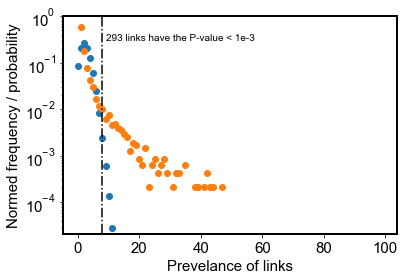

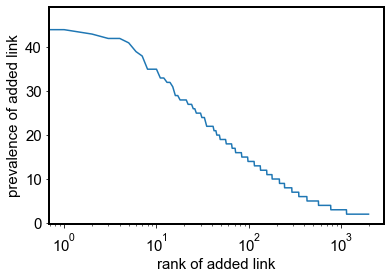

In [11]:
from scipy.stats import bernoulli, binom
NUMSIM = len(df)
xx = range(NUMSIM)
p = np.mean(numLinksAdded) / 5000
probCum = binom.cdf(xx, NUMSIM, p)
prob = binom.pmf(xx, NUMSIM, p)
threshold = np.where(probCum > 1 - 1e-3)[0][0]

x_prevalence = Counter(df_all['position in x'])
i_prevalence = np.array(list(x_prevalence.keys()))[[np.array(list(x_prevalence.values())) >= threshold][0]]

df_prevalence = df_all.set_index('position in x').loc[i_prevalence].reset_index().drop_duplicates('position in x')
len(df_prevalence)

numOfSigLinks = np.sum(np.array(list(x_prevalence.values())) >= threshold)
numOfTotalLinks = np.array(list(x_prevalence.values())).shape[0]
print('Number of significant links and total links is:')
print(numOfSigLinks, numOfTotalLinks)
print(numOfSigLinks / numOfTotalLinks)

distOfPrev = Counter(np.array(list(x_prevalence.values())))
plt.plot(xx, prob, 'o')
dist_x = np.array(list(distOfPrev.keys()))
dist_y = np.array(list(distOfPrev.values())) / np.sum(np.array(list(distOfPrev.values())))
plt.plot(dist_x, dist_y, 'o')
plt.plot([threshold, threshold], [0, 1], 'k-.')
plt.yscale('log'); plt.ylim([np.min(dist_y)/10, 1])
plt.xlabel('Prevelance of links')
plt.ylabel('Normed frequency / probability')
plt.text(threshold+1, 0.3, str(numOfSigLinks)+' links have the P-value < 1e-3');

rankOfPrev = np.sort(np.array(list(x_prevalence.values())))[::-1]

plt.figure()
plt.plot(list(range(len(rankOfPrev[rankOfPrev > 1]))), rankOfPrev[rankOfPrev > 1])
plt.xscale('log')
plt.xlabel('rank of added link')
plt.ylabel('prevalence of added link')

In [59]:
print(np.unique(df_MAMBO_filtered['metabolite_ID']).shape[0], MAX_ID_metabolites)
print(np.unique(df_MAMBO_filtered['microbe_ID']).shape[0], MAX_ID_microbes)
#names.loc[np.unique(df_MAMBO_filtered['metabolite_ID'])]
net.columns

NameError: name 'df_MAMBO_filtered' is not defined

/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


6775 30749
0.22033236853231
209
105
P-value is 2.5369026990240684e-08


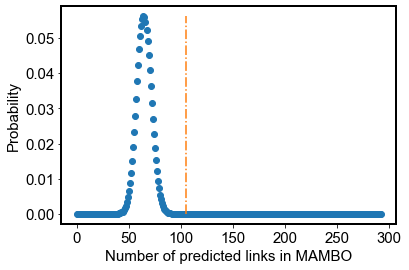

In [60]:
NUMADDED = df_prevalence.shape[0]

max_links = MAX_ID_metabolites * MAX_ID_microbes
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("../mambo_curated.txt", sep = '\t')
df_MAMBO_temp = df_MAMBO.copy()
df_MAMBO['edge_type'][df_MAMBO['edge_type']==5] = 2
df_MAMBO_temp['edge_type'][df_MAMBO_temp['edge_type']==5] = 3
df_MAMBO = df_MAMBO.append(df_MAMBO_temp).drop_duplicates()

df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['metabolite_ID', 'microbe_ID', 'edge_type']].copy()
df_MAMBO_filtered_newID.columns = net.columns
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values

s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(df_MAMBO_filtered_newID, net))

#max_size = np.unique(df_MAMBO_filtered['metabolite_ID']).shape[0] * np.unique(df_MAMBO_filtered['microbe_ID']).shape[0]

print((len(df_MAMBO_filtered) - numOverlap), (2*max_links - len(net_ori)))
print((len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_prevalence['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_prevalence['metabolite ID'].iloc[i]))>=1 and 
       np.sum((df_MAMBO['edge_type'] == df_prevalence['edgeType'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_prevalence['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_prevalence['metabolite ID'].iloc[i]) & 
         (df_MAMBO['edge_type'] == df_prevalence['edgeType'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
#typeCounts = Counter(df_MAMBO_filtered['edge_type'])
#p = (typeCounts[2] + typeCounts[3] + 2 * typeCounts[5] - numOverlap) / (2*max_links - len(net_ori))
p = (len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori))
#p = (203 + 3589 * 2) / (2*max_links)
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))


In [61]:
#df_unique = df_all.drop_duplicates('position in x')

net_prevalent = df_prevalence[['metabolite ID', 'microbes ID', 'edgeType', 'position in x']].set_index('position in x')
prev_sig = {x : y for (x, y) in x_prevalence.items() if x in list(net_prevalent.index)}
xx = range(NUMSIM)
p = np.mean(numLinksAdded) / 5000
probCum = binom.cdf(xx, NUMSIM, p)
pvalue = 1-probCum[np.array(list(x_prevalence.values()))]
pvalue_sig = 1-probCum[np.array(list(prev_sig.values()))]

net_chia = net.copy()
net_chia['ifAdded'] = [0] * len(net_chia)
net_prevalent['ifAdded'] = [1] * len(net_prevalent)
net_prevalent.columns = net_chia.columns
net_prevalent['microbes'] = df_microbes.loc[net_prevalent['microbes'].values].values.flatten()
net_prevalent['metabolites'] = df_metabolites.loc[net_prevalent['metabolites'].values].values.flatten()
net_full = net_chia.append(net_prevalent)
net_full.head()



,metabolites,microbes,edgeType,ifAdded
0,2,16,3,0
1,3,23,3,0
2,3,16,3,0
3,6,61,2,0
4,7,5,2,0


In [14]:

'''
net_prevalent = df_prevalence[['metabolite ID', 'microbes ID', 'edgeType', 'position in x']].set_index('position in x')
prev_sig = {x : y for (x, y) in x_prevalence.items() if x in list(net_prevalent.index)}
xx = range(NUMSIM)
p = np.mean(numLinksAdded) / 5000
probCum = binom.cdf(xx, NUMSIM, p)
pvalue = 1-probCum[np.array(list(x_prevalence.values()))]
pvalue_sig = 1-probCum[np.array(list(prev_sig.values()))]

net_chia = net.copy()
net_chia['pvalue'] = [0] * len(net_chia)
net_chia['metabolites'] = df_metabolites.reset_index().set_index('newID').loc[net_chia['metabolites']].values.flatten()
net_chia['microbes'] = df_microbes.reset_index().set_index('newID').loc[net_chia['microbes']].values.flatten()
net_prevalent['pvalue'] = pvalue_sig
net_prevalent.columns = net_chia.columns
#net_prevalent['microbes'] = df_microbes.loc[net_prevalent['microbes'].values].values.flatten()
#net_prevalent['metabolites'] = df_metabolites.loc[net_prevalent['metabolites'].values].values.flatten()
net_to_veronika = net_chia.append(net_prevalent)
net_to_veronika.head()
net_to_veronika.to_csv('chia_network_with_prevalent_links.csv')
'''

"\nnet_prevalent = df_prevalence[['metabolite ID', 'microbes ID', 'edgeType', 'position in x']].set_index('position in x')\nprev_sig = {x : y for (x, y) in x_prevalence.items() if x in list(net_prevalent.index)}\nxx = range(NUMSIM)\np = np.mean(numLinksAdded) / 5000\nprobCum = binom.cdf(xx, NUMSIM, p)\npvalue = 1-probCum[np.array(list(x_prevalence.values()))]\npvalue_sig = 1-probCum[np.array(list(prev_sig.values()))]\n\nnet_chia = net.copy()\nnet_chia['pvalue'] = [0] * len(net_chia)\nnet_chia['metabolites'] = df_metabolites.reset_index().set_index('newID').loc[net_chia['metabolites']].values.flatten()\nnet_chia['microbes'] = df_microbes.reset_index().set_index('newID').loc[net_chia['microbes']].values.flatten()\nnet_prevalent['pvalue'] = pvalue_sig\nnet_prevalent.columns = net_chia.columns\n#net_prevalent['microbes'] = df_microbes.loc[net_prevalent['microbes'].values].values.flatten()\n#net_prevalent['metabolites'] = df_metabolites.loc[net_prevalent['metabolites'].values].values.flatte

In [62]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
#netNUM = 0
#netNUM = 95
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added])

corr_list = np.zeros((thai_metabolome.shape[1],2))
diet_list = np.zeros((thai_metabolome.shape[1], 20))
log_list = np.zeros((thai_metabolome.shape[1],2))
numMet_list = np.zeros((thai_metabolome.shape[1]))
metagenome_predicted = np.zeros((thai_metabolome.shape[1], thai_metagenome_ID.shape[0]))
metabolome_predicted = np.zeros((thai_metabolome.shape[1], thai_metabolome_ID.shape[0]))
for pa in range(thai_metabolome.shape[1]):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    
    metagenome_predicted[pa, :] = ba_pred[thai_metagenome_ID]
    metabolome_predicted[pa, :] = metabolome_pred[thai_metabolome_ID]
    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    numMet_list[pa] = i_common.shape[0]
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
#'''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(corr_list[:,1]))
print('Average log10 accuracy between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))
print('Average number of metabolites overlapped between predicted and experimentally measured metabolome:')
print(np.mean(numMet_list))
#'''
#corr_allreplicates.append(np.mean(corr_list[:,1]))
#log10_allreplicates.append(np.mean(log_list[:,1]))


NameError: name 'Ain_out' is not defined

## Pcolor plots for prevalent links

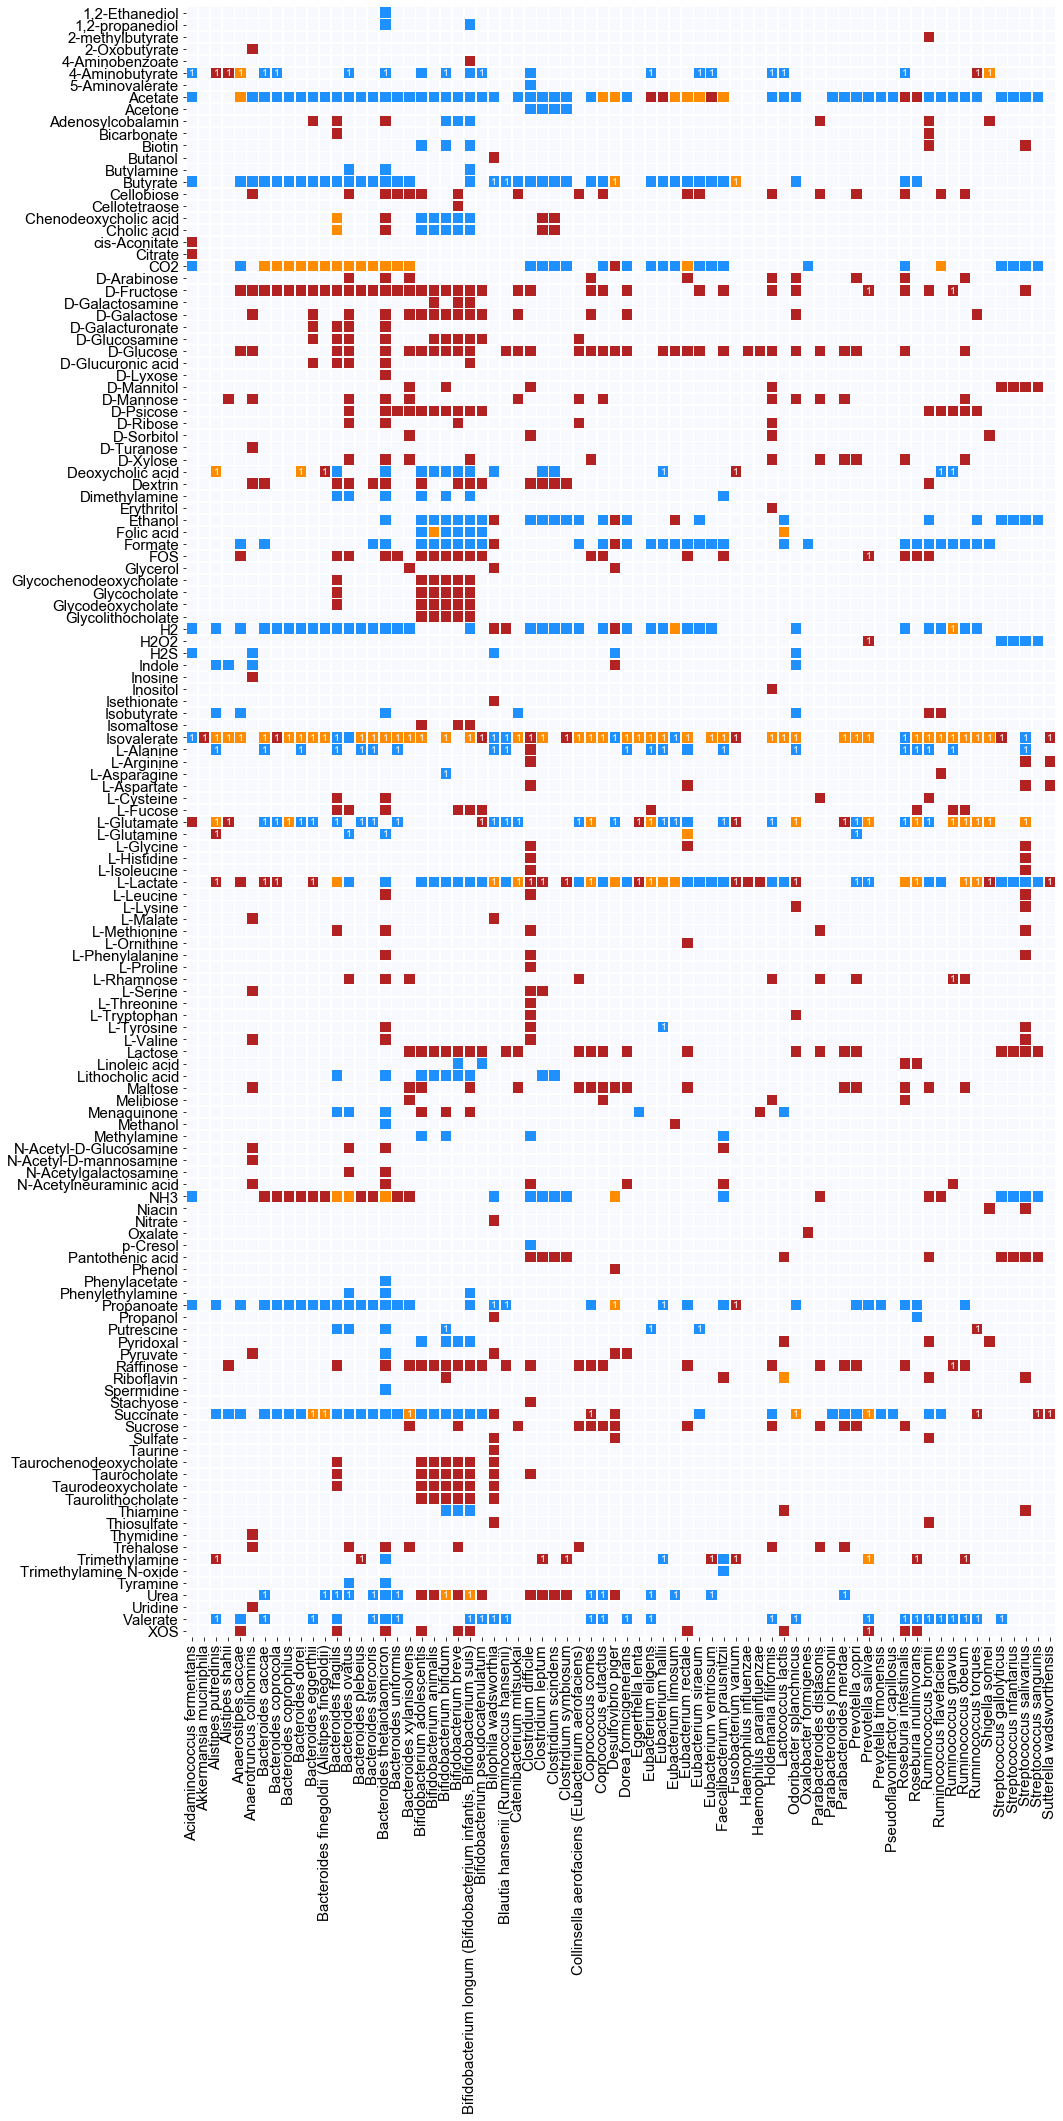

In [88]:
import matplotlib as mpl
colors = ['ghostwhite','firebrick','dodgerblue','darkorange']
cmap = mpl.colors.ListedColormap(colors)

i_nonempty_metabolites = np.unique(net_full['metabolites'].values)

net_label1 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_label2 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))

net_full_matrix1 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_full_subset1 = net_full[net_full['edgeType']==2]
net_full_matrix1[net_full_subset1['metabolites'].values, net_full_subset1['microbes'].values] = 1
net_label1[net_full_subset1['metabolites'].values, net_full_subset1['microbes'].values] = net_full_subset1['ifAdded'].values

net_full_matrix2 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_full_subset2 = net_full[net_full['edgeType']==3]
net_full_matrix2[net_full_subset2['metabolites'].values, net_full_subset2['microbes'].values] = 2
net_label2[net_full_subset2['metabolites'].values, net_full_subset2['microbes'].values] = net_full_subset2['ifAdded'].values

net_label = net_label1 + net_label2
net_label[net_label > 0] = 1
net_label = net_label[i_nonempty_metabolites,:]
net_full_matrix = net_full_matrix1 + net_full_matrix2

index_name = list(names.loc[df_metabolites.reset_index().set_index('newID').loc[i_nonempty_metabolites].values.flatten()].values.flatten())
col_name = list(names.loc[np.array(list(df_microbes.index))].values.flatten())
index_name = list(map(lambda x:x.split(' (')[0], index_name))

df_net_full = pd.DataFrame(data=net_full_matrix[i_nonempty_metabolites,:], index=index_name, columns=col_name)
#df_net_full = df_net_full.iloc[np.where(df_net_full.values.sum(1))[0], :]
#df_net_full = df_net_full.iloc[:, np.where(df_net_full.values.sum(0))[0]]

#g = sns.clustermap(df_net_full, figsize=(30,30), center=0, cmap='vlag', linewidths=0.75, annot=net_label)
#g = sns.clustermap(df_net_full, figsize=(30,30), center=0, cmap='vlag', linewidths=0.75)
#g = sns.clustermap(df_net_full, figsize=(30,30), linewidths=0.75)
#g.ax_heatmap.set_xlabel('Microbes')
#g.ax_heatmap.set_ylabel('Metabolites')

show_annot_array = (net_label > 0)
fig, ax = plt.subplots(1,1,figsize=(30,30))
sns.heatmap(df_net_full, ax = ax, center=2, cmap=cmap, linewidths=0.75, annot=net_label, square=True, cbar=False,
           xticklabels = True, yticklabels = True)
for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
    text.set_visible(show_annot)
    
#plt.savefig("./pcolor_network_added.svg")


In [17]:
i_nonempty_metabolites = np.unique(net_full['metabolites'].values)

net_full_matrix1 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_full_subset1 = net_full[net_full['edgeType']==2]
net_full_matrix1[net_full_subset1['metabolites'].values, net_full_subset1['microbes'].values] = net_full_subset1['ifAdded'].values + 1
net_full_matrix2 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_full_subset2 = net_full[net_full['edgeType']==3]
net_full_matrix2[net_full_subset2['metabolites'].values, net_full_subset2['microbes'].values] = - (net_full_subset2['ifAdded'].values + 1)

index_name = list(names.loc[df_metabolites.reset_index().set_index('newID').loc[i_nonempty_metabolites].values.flatten()].values.flatten())
col_name = list(names.loc[np.array(list(df_microbes.index))].values.flatten())
index_name = list(map(lambda x:x.split(' (')[0], index_name))

df_net_full = pd.DataFrame(data=net_full_matrix[i_nonempty_metabolites,:], index=index_name, columns=col_name)
df_net_full = df_net_full.iloc[np.where(df_net_full.values.sum(1))[0], :]
df_net_full = df_net_full.iloc[:, np.where(df_net_full.values.sum(0))[0]]
g = sns.clustermap(df_net_full, figsize=(30,30), center=0, cmap='vlag', linewidths=0.75, annot=True)
#g = sns.heatmap(df_net_full)
#sns.palplot(sns.color_palette("hls", 8))
g.ax_heatmap.set_xlabel('Microbes')
g.ax_heatmap.set_ylabel('Metabolites')
#g.ax_heatmap.set_title('Consumption links')



-290.0

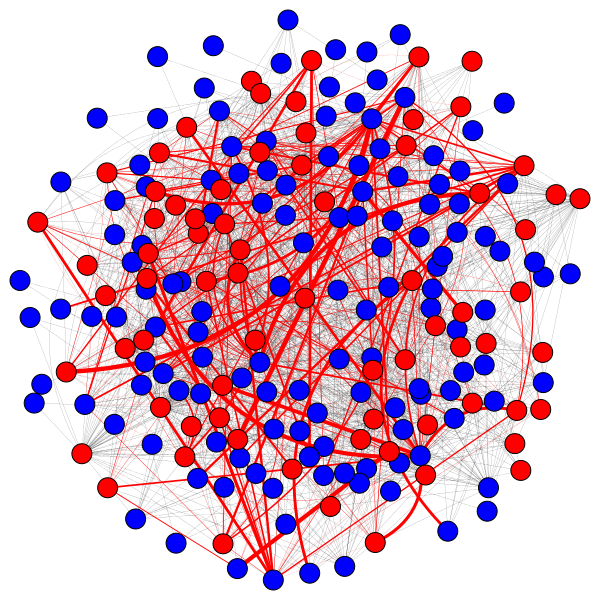

In [468]:
s1 = MAX_ID_metabolites2
s2 = MAX_ID_microbes
nodelist = [0] * s1 + [1] * s2
edgelist = np.array(np.where((net_full_matrix > 0).tolist())).transpose().tolist()
g = ig.Graph.Bipartite(nodelist, edgelist)
g.vs['color'] = ['blue'] * s1 + ['red'] * s2
#g.es['width'] = [0.1] * np.sum(net_full['ifAdded']==0) + list(-np.log10(pvalue_sig)*0.1)
g.es['width'] = [0.1] * np.sum(net_full['ifAdded']==0) + list(np.array(list(x_prevalence.values()))*0.1)
g.es['color'] = ['black'] * np.sum(net_full['ifAdded']==0) + ['red'] * np.sum(net_full['ifAdded']==1)
#g.es['color'] = ['black'] * np.sum(net_full['ifAdded']==0) + ['red'] * np.sum(net_full['ifAdded']==1)
#layout = g.layout_bipartite()
#layout = g.layout_fruchterman_reingold()
layout = g.layout_auto(repulserad=1e-2)
ig.plot(g, layout = layout)


## Run the simulation with reduced matrix forms for one individual

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.2986932508967106
            Iterations: 14
            Function evaluations: 310
            Gradient evaluations: 14
     fun: 3.2986932508967106
     jac: array([ 0.        , -0.00607041,  0.00249973,  0.00244379,  0.01342097,
        0.01750383,  0.01855433,  0.00281239,  0.00334352,  0.01648417,
       -0.00632995,  0.00306493,  0.02916449,  0.05973503, -0.00965661,
        0.0092881 ,  0.1019651 ,  0.00812569,  0.00533977,  0.02321699])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.00000000e-02, 2.88444573e-03, 1.21632546e+00, 9.06181188e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36143685e-02, 0.00000000e+00, 1.45227455e-01, 1.21038497e+00,
       2.98634689e-17, 3.27114524e-17, 8.90697495e-01, 5.52302836e-01,
       4.27068948e-18, 1.59140976e-02, 5.64292766

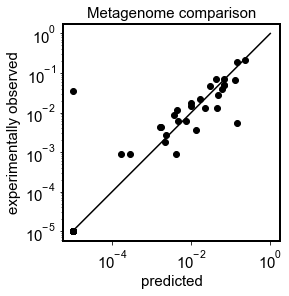

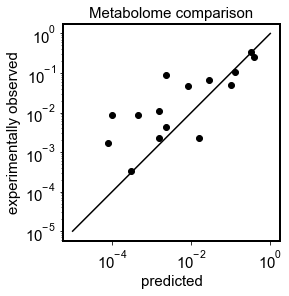

In [12]:
################################# Predict metabolome from individual's metagenome.
from numpy import array
from scipy.sparse import csr_matrix
import numpy.matlib
from scipy.optimize import minimize, rosen, rosen_der
from scipy.stats import pearsonr

MAX_ID_microbes = len(i_nonzero_microbes)  # MAX_ID_microbes is the maximum of ID labels for microbes.
MAX_ID_metabolites = len(i_nonzero_metabolites)  # MAX_ID_metabolites is the maximum of ID labels for metabolites.

def Ain_out(b_real, net):
    '''
    Ain_out is a function used to create sparse matrices made of metabolites and microbes 
    where metabolite consumption and production is considered. The matrices created are "m2b" and "b2m":
    (1) m2b is a matrix determines the nutrient splitting among microbes, and
    (2) b2m is a matrix determines the byproducts generation.
    Both matrices have rows representing bacterial species and columns representing metablolites.
    Two matrices are created based on (1) the metabolite consumption and production network which is 
    encode in "net" as a dataframe, and (2) the experimentally measured bacterial abundance "b_real".
    '''
    valid_index = np.where((net['edgeType']==2) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    m2b = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    valid_index = np.where((net['edgeType']==3) | (net['edgeType']==5))[0]
    row = net['metabolites'].iloc[valid_index]
    col = net['microbes'].iloc[valid_index]
    data = np.ones((len(valid_index),))
    b2m = csr_matrix( (data,(row,col)), shape=(MAX_ID_metabolites, MAX_ID_microbes)).toarray()#.todense()

    ########## Normalize the b2m by out_degree
    out_degree = b2m.sum(0).copy()
    out_degree[out_degree==0]=100
    b2m = (b2m / out_degree)

    ########## Normalize the m2b by proportion of microbial abundance in each individual
    b_real_repmat = numpy.matlib.repmat(b_real[np.newaxis,:], MAX_ID_metabolites, 1)
    m2b = m2b * b_real_repmat
    in_degree = m2b.sum(1)
    in_degree[in_degree==0]=100
    m2b = m2b / numpy.matlib.repmat(in_degree[:,np.newaxis], 1, MAX_ID_microbes)
    m2b = np.float32(m2b)
    b2m = np.float32(b2m)
    return [m2b, b2m]

def m2b_multiple_levels(f, m2b, b2m, numLevels_max):
    '''
    m2b_multiple_levels is a function used to generate matrices involving the calculation of metabolite 
    byproducts and microbial biomass after several trophic levels/layers. Those matrices are:
    (1) m2m_layer is a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic
    level or layer.
    (2) m2m_total is a conversion matrix from the nutrient intake to a summation of metabolite byproducts at
    all trophic levels or layers.
    (3) m2b_total is a conversion matrix from the nutrient intake to a summation of all microbial/bacterial 
    biomass gain at all trophic levels or layers.
    Those matrices are computed based on (1) metabolite consumption matrix "m2b", (2) metabolite byproduct
    generation matrix "b2m", (3) byproduct/leakage fraction "f", and (4) number of trophic levels/layers in the 
    simulation "numLevels_max".
    '''
    m2m_layer = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites, numLevels_max));  
    #m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_microbes));  
    m2b_total = np.zeros((MAX_ID_metabolites, MAX_ID_metabolites));  
    
    f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    #s_step =  np.dot(b2m, m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step =  np.dot(b2m, f_mul*m2b.T) # s_step is the conversion matrix of each trophic level/layer
    s_step_ii = np.eye(MAX_ID_metabolites, MAX_ID_metabolites);
    #f_mul = numpy.matlib.repmat(f[np.newaxis,:], MAX_ID, 1)#numpy.matlib.repmat(f, 1, MAX_ID)
    #f_mul = numpy.matlib.repmat(f, 1, MAX_ID_metabolites)
    
    for ii in range(numLevels_max):
        # m2b_total is a series made of s_step of each layer
        #m2b_total = m2b_total + f_mul**(ii) * s_step_ii
        #m2m_layer[:,:,ii] = f_mul**(ii) * s_step_ii
        m2b_total = m2b_total + s_step_ii
        m2m_layer[:,:,ii] = s_step_ii
        s_step_ii = np.dot(s_step_ii, s_step);  
    m2m_total = m2b_total;
    m2b_total = np.dot((1 - f_mul) * m2b.T, m2b_total) # m2b_total has an extra multiplication of m2b and (1-f).
    return [m2b_total, m2m_total, m2m_layer]

def pred_error(x, b_real, m2b_total, i_intake):
    '''
    pred_error is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    ba_pred = np.dot(m2b_total, x_full)
    pred_error = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    pred_error = np.sqrt(np.dot(pred_error, pred_error.T)) #np.sqrt(np.sum(pred_error**2))
    return pred_error

def calc_metabolome(x, m2m_layer, numLevels_max, i_intake):
    '''
    calc_metabolome is a function used to calculate the metabolome from the fitted nutrient intake from the
    model. It relies on (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2m_layer: 
    a conversion matrix from the nutrient intake to the metabolite byproducts at a trophic level or layer, 
    and (4) numLevels_max: the number of trophic levels/layers in the model. The metabolome in the model is 
    assumed to be composed of two parts: (1) met_levels: all metabolites in the final trophic level/layer 
    (which is considered to be reaching the end of the gut because of the finite gut length and gut motility.),
    and (2) met_leftover_levels: all unusable metabolites from all previous trophic levels/layers. 
    '''
    i_unused = np.where(np.sum(m2b.T,0) == 0)[0]
    met_levels = np.zeros((MAX_ID_metabolites, numLevels_max));  
    met_leftover_levels = np.zeros((MAX_ID_metabolites, numLevels_max));
    
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = x;
    
    for ii in range(numLevels_max):
        met_levels[:,ii] = np.dot(m2m_layer[:,:,ii], x_full)
        if ii==0:
            met_leftover_levels[i_unused,ii] = x_full[i_unused]
        else:
            met_leftover_levels[i_unused,ii] = met_levels[i_unused,ii-1]
            
    return [met_levels, met_leftover_levels]

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))


In [70]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
for netNUM in range(len(df)):
    #netNUM = 0
    net_added = df[netNUM].iloc[:, np.array([0,2,4])]
    net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
    net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
    net_added.columns = net.columns

    net_new = pd.concat([net_ori, net_added])

    corr_list = np.zeros((41,2))
    diet_list = np.zeros((41, 20))
    log_list = np.zeros((41,2))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net_new)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

        corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
        log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        diet_list[pa, :] = res.x
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''
    '''
    print('Average correlation coefficient of the correlation between predicted and experimentally measured metagonome:')
    print(np.mean(corr_list[:,1]))
    print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
    print(np.mean(log_list[:,1]))
    '''
    corr_allreplicates.append(np.mean(corr_list[:,1]))
    log10_allreplicates.append(np.mean(log_list[:,1]))


/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


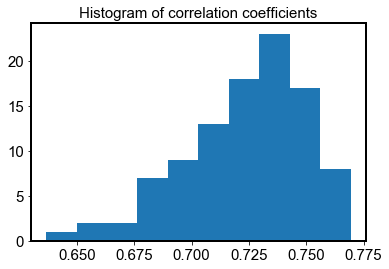

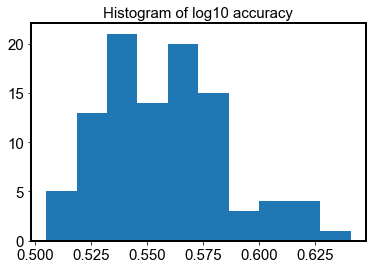

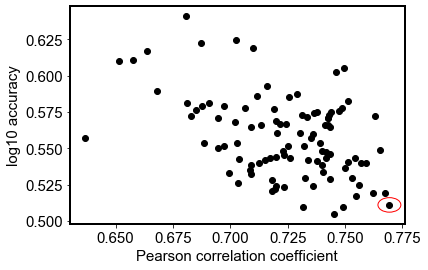

In [77]:
plt.figure()
plt.hist(corr_allreplicates)
plt.title('Histogram of correlation coefficients')

plt.figure()
plt.hist(log10_allreplicates)
plt.title('Histogram of log10 accuracy')

plt.figure()
plt.plot(corr_allreplicates, log10_allreplicates, 'ko')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('log10 accuracy')
netNUM = np.argsort(corr_allreplicates)[-1]
circle1 = plt.Circle((corr_allreplicates[netNUM], log10_allreplicates[netNUM]), 5e-3, color='red', fill=False)
ax = plt.gca()
ax.add_artist(circle1)
plt.savefig('./figures/fig1F.svg')


In [78]:
pearsonr(corr_allreplicates, log10_allreplicates)

(-0.4492280722524845, 2.7561575597411855e-06)

In [79]:
np.where(np.array(corr_allreplicates) > 0.768)[0]

array([53])

/Users/tongwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9857278620753906
            Iterations: 20
            Function evaluations: 442
            Gradient evaluations: 20
     fun: 0.9857278620753906
     jac: array([ 0.00000000e+00,  8.25661421e-02, -1.28640980e-03,  3.96168977e-02,
       -3.28989327e-03,  1.52466893e-02,  2.43465826e-02,  6.78772554e-02,
       -1.02054849e-02,  9.31986049e-02,  1.90305233e-01,  1.12611800e-02,
        6.35419041e-02,  3.33211176e-01,  4.24441695e-03,  3.70829925e-02,
        2.15500236e-01,  1.56280838e-01, -2.03102827e-05,  9.39438567e-02])
 message: 'Optimization terminated successfully.'
    nfev: 442
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([5.00000000e-02, 5.25350909e-16, 2.81578501e+00, 4.40855089e-16,
       1.01234882e-01, 2.39636268e-16, 0.00000000e+00, 3.59674520e-16,
       1.57765445e-02, 0.00000000e+00, 2.24729638e-15, 0.00000000e+00,
       0.00000000e+00, 2.07574421

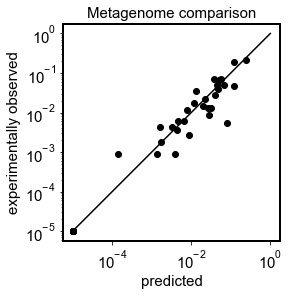

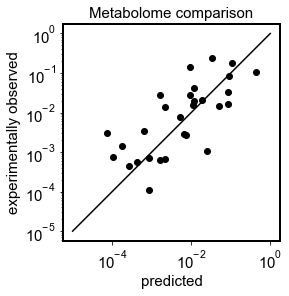

In [140]:
#netNUM = 7
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added])
#net_new = pd.concat([net_ori, net_added, net_added_full])

f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
#print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))
print(i_common.shape[0])


## Generate the correlation and log10 accuracy for one of simulated result with added links

In [112]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()
#netNUM = 0
#netNUM = 95
net_added = df[netNUM].iloc[:, np.array([0,2,4])]
net_added.iloc[:,0] = df_metabolites.loc[net_added.iloc[:,0]].values
net_added.iloc[:,1] = df_microbes.loc[net_added.iloc[:,1]].values
net_added.columns = net.columns

net_new = pd.concat([net_ori, net_added])

corr_list = np.zeros((thai_metabolome.shape[1],2))
diet_list = np.zeros((thai_metabolome.shape[1], 20))
log_list = np.zeros((thai_metabolome.shape[1],2))
numMet_list = np.zeros((thai_metabolome.shape[1]))
metagenome_predicted = np.zeros((thai_metabolome.shape[1], thai_metagenome_ID.shape[0]))
metabolome_predicted = np.zeros((thai_metabolome.shape[1], thai_metabolome_ID.shape[0]))
for pa in range(thai_metabolome.shape[1]):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_new)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    
    metagenome_predicted[pa, :] = ba_pred[thai_metagenome_ID]
    metabolome_predicted[pa, :] = metabolome_pred[thai_metabolome_ID]
    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    numMet_list[pa] = i_common.shape[0]
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
#'''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(corr_list[:,1]))
print('Average log10 accuracy between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))
print('Average number of metabolites overlapped between predicted and experimentally measured metabolome:')
print(np.mean(numMet_list))
#'''
#corr_allreplicates.append(np.mean(corr_list[:,1]))
#log10_allreplicates.append(np.mean(log_list[:,1]))


Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:
0.769307826470807
Average log10 accuracy between predicted and experimentally measured metabolome:
0.5110612569845648
Average number of metabolites overlapped between predicted and experimentally measured metabolome:
30.634146341463413


## Generate the prediction for one individual by using the original Chia network

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.2986932508967106
            Iterations: 14
            Function evaluations: 310
            Gradient evaluations: 14
     fun: 3.2986932508967106
     jac: array([ 0.        , -0.00607041,  0.00249973,  0.00244379,  0.01342097,
        0.01750383,  0.01855433,  0.00281239,  0.00334352,  0.01648417,
       -0.00632995,  0.00306493,  0.02916449,  0.05973503, -0.00965661,
        0.0092881 ,  0.1019651 ,  0.00812569,  0.00533977,  0.02321699])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.00000000e-02, 2.88444573e-03, 1.21632546e+00, 9.06181188e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36143685e-02, 0.00000000e+00, 1.45227455e-01, 1.21038497e+00,
       2.98634689e-17, 3.27114524e-17, 8.90697495e-01, 5.52302836e-01,
       4.27068948e-18, 1.59140976e-02, 5.64292766

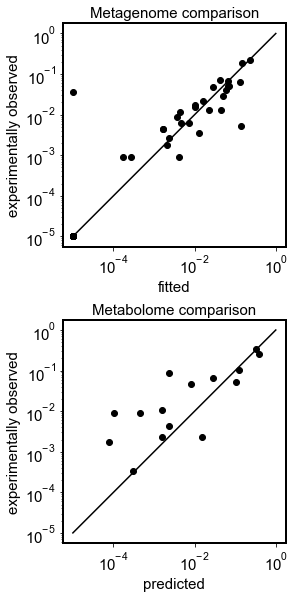

In [113]:
f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, axes = plt.subplots(2,1,figsize=(4,10))
axes[0].loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
axes[0].plot([1e-5, 1], [1e-5, 1],'k-')
axes[0].set_aspect('equal')
axes[0].set_xlabel('fitted')
axes[0].set_ylabel('experimentally observed')
axes[0].set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
axes[1].loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
axes[1].plot([1e-5, 1], [1e-5, 1],'k-')
axes[1].set_aspect('equal')
axes[1].set_xlabel('predicted')
axes[1].set_ylabel('experimentally observed')
axes[1].set_title('Metabolome comparison')
fig.savefig('./figures/fig3A.svg')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

## Generate the prediction for one individual by using the network with added links

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9857278620753906
            Iterations: 20
            Function evaluations: 442
            Gradient evaluations: 20
     fun: 0.9857278620753906
     jac: array([ 0.00000000e+00,  8.25661421e-02, -1.28640980e-03,  3.96168977e-02,
       -3.28989327e-03,  1.52466893e-02,  2.43465826e-02,  6.78772554e-02,
       -1.02054849e-02,  9.31986049e-02,  1.90305233e-01,  1.12611800e-02,
        6.35419041e-02,  3.33211176e-01,  4.24441695e-03,  3.70829925e-02,
        2.15500236e-01,  1.56280838e-01, -2.03102827e-05,  9.39438567e-02])
 message: 'Optimization terminated successfully.'
    nfev: 442
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([5.00000000e-02, 5.25350909e-16, 2.81578501e+00, 4.40855089e-16,
       1.01234882e-01, 2.39636268e-16, 0.00000000e+00, 3.59674520e-16,
       1.57765445e-02, 0.00000000e+00, 2.24729638e-15, 0.00000000e+00,
       0.00000000e+00, 2.07574421

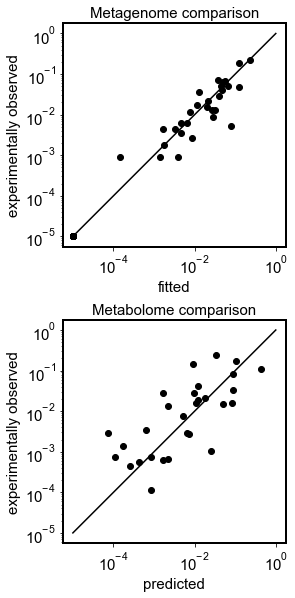

In [114]:
f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
#pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net_new)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, axes = plt.subplots(2,1,figsize=(4,10))
axes[0].loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
axes[0].plot([1e-5, 1], [1e-5, 1],'k-')
axes[0].set_aspect('equal')
axes[0].set_xlabel('fitted')
axes[0].set_ylabel('experimentally observed')
axes[0].set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
axes[1].loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
axes[1].plot([1e-5, 1], [1e-5, 1],'k-')
axes[1].set_aspect('equal')
axes[1].set_xlabel('predicted')
axes[1].set_ylabel('experimentally observed')
axes[1].set_title('Metabolome comparison')
fig.savefig('./figures/fig3C.svg')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
print(pearsonr(metabolome_pred_common, metabolome_measured_common))

## Generate the correlation and log10 accuracy for the original Chia network

In [115]:
######## Convert x to net structure:
corr_allreplicates = []
log10_allreplicates = []
net_ori = net.copy()

corr_list = np.zeros((thai_metabolome.shape[1],2))
diet_list = np.zeros((thai_metabolome.shape[1], 20))
log_list = np.zeros((thai_metabolome.shape[1],2))
numMet_list = np.zeros((thai_metabolome.shape[1]))
metagenome_predicted_chia = np.zeros((thai_metabolome.shape[1], thai_metagenome_ID.shape[0]))
metabolome_predicted_chia = np.zeros((thai_metabolome.shape[1], thai_metabolome_ID.shape[0]))
for pa in range(thai_metabolome.shape[1]):
    #print(pa)
    ######## Select an ID of a individual and pull out its experimentally measured metagenome:
    b_real = np.zeros((MAX_ID_microbes,))
    b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

    ######## Compute matrices involving the metabolite consumption and generation:
    m2b, b2m = Ain_out(b_real, net_ori)
    #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
    m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

    ######## Assign diet
    x0 = np.ones((len(i_intake),)) / len(i_intake)

    ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
    # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
    # from the model for a certain nutrient intake.
    fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
    bnds = ((0, 100), ) * len(x0)
    res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'maxiter': 1000}, tol=1e-3)

    ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
    # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
    # visually and statistically compared to the experimentally measured metagenome and metabolome.
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    ba_pred = np.dot(m2b_total, x_full)

    met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
    metabolome_measured = np.zeros((MAX_ID_metabolites,))
    metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
    metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
    i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
    metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
    metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
    
    metagenome_predicted_chia[pa, :] = ba_pred[thai_metagenome_ID]
    metabolome_predicted_chia[pa, :] = metabolome_pred[thai_metabolome_ID]
    corr_list[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
    #corr_list[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
    corr_list[pa, 1] = pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5))[0]
    log_list[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
    log_list[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
    diet_list[pa, :] = res.x
    numMet_list[pa] = i_common.shape[0]
    '''
    print('-------------------------------------------------------------------------------------------------------------')
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
    print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
    print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
    print(pearsonr(metabolome_pred_common, metabolome_measured_common))
    '''
#'''
print('Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:')
print(np.mean(corr_list[:,1]))
print('Average log10 accuracy between predicted and experimentally measured metabolome:')
print(np.mean(log_list[:,1]))
print('Average number of metabolites overlapped between predicted and experimentally measured metabolome:')
print(np.mean(numMet_list))
#'''
#corr_allreplicates.append(np.mean(corr_list[:,1]))
#log10_allreplicates.append(np.mean(log_list[:,1]))


Average correlation coefficient of the correlation between predicted and experimentally measured metabolome:
0.6108124558596347
Average log10 accuracy between predicted and experimentally measured metabolome:
0.864228051142719
Average number of metabolites overlapped between predicted and experimentally measured metabolome:
17.341463414634145


## Pcolor plots for prevalent links

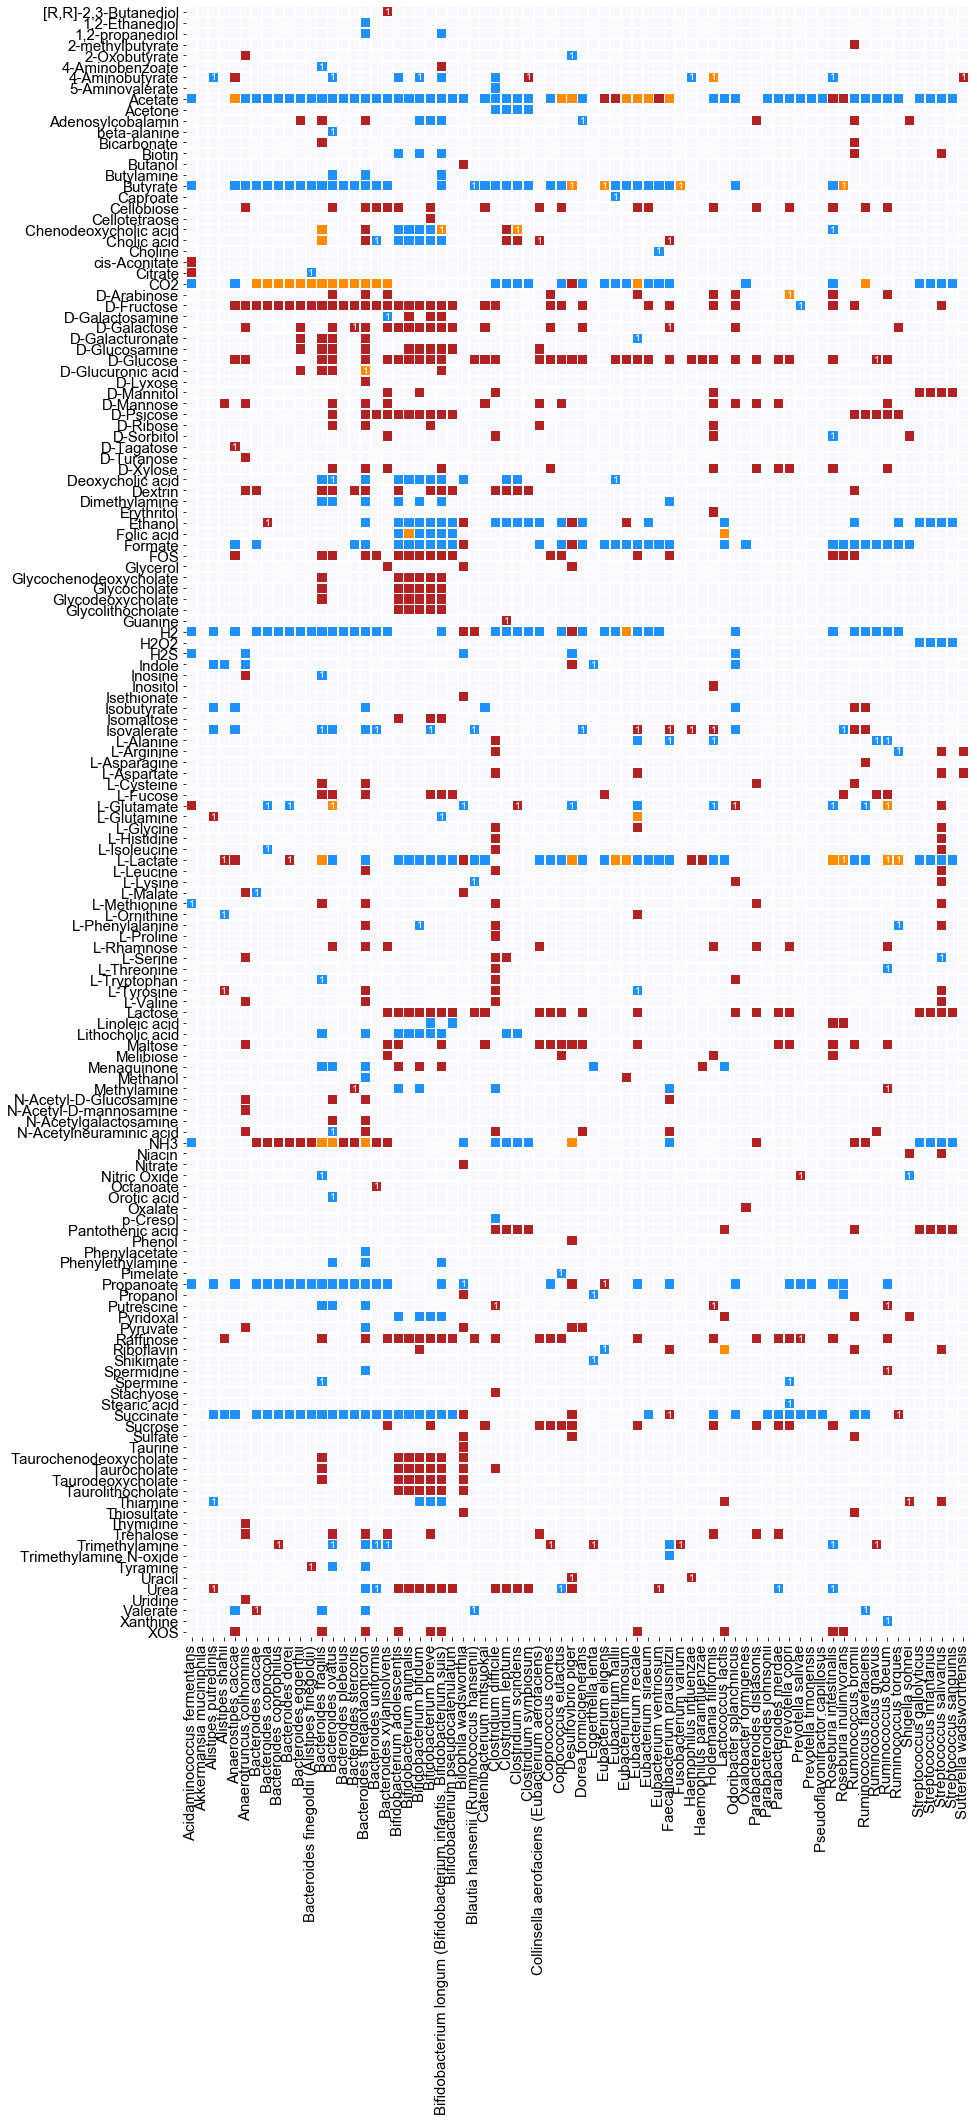

In [116]:
import matplotlib as mpl
net_newAll = net_new.copy()
net_newAll['ifAdded'] = [0] * len(net_newAll)
net_newAll['ifAdded'].iloc[-len(net_added):] = 1

colors = ['ghostwhite','firebrick','dodgerblue','darkorange']
cmap = mpl.colors.ListedColormap(colors)

i_nonempty_metabolites = np.unique(net_newAll['metabolites'].values)

net_label1 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_label2 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))

net_newAll_matrix1 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_newAll_subset1 = net_newAll[net_newAll['edgeType']==2]
net_newAll_matrix1[net_newAll_subset1['metabolites'].values, net_newAll_subset1['microbes'].values] = 1
net_label1[net_newAll_subset1['metabolites'].values, net_newAll_subset1['microbes'].values] = net_newAll_subset1['ifAdded'].values

net_newAll_matrix2 = np.zeros((MAX_ID_metabolites, MAX_ID_microbes))
net_newAll_subset2 = net_newAll[net_newAll['edgeType']==3]
net_newAll_matrix2[net_newAll_subset2['metabolites'].values, net_newAll_subset2['microbes'].values] = 2
net_label2[net_newAll_subset2['metabolites'].values, net_newAll_subset2['microbes'].values] = net_newAll_subset2['ifAdded'].values

net_label = net_label1 + net_label2
net_label[net_label > 0] = 1
net_label = net_label[i_nonempty_metabolites,:]
net_newAll_matrix = net_newAll_matrix1 + net_newAll_matrix2

index_name = list(names.loc[df_metabolites.reset_index().set_index('newID').loc[i_nonempty_metabolites].values.flatten()].values.flatten())
col_name = list(names.loc[np.array(list(df_microbes.index))].values.flatten())
index_name = list(map(lambda x:x.split(' (')[0], index_name))

df_net_newAll = pd.DataFrame(data=net_newAll_matrix[i_nonempty_metabolites,:], index=index_name, columns=col_name)

show_annot_array = (net_label > 0)
fig, ax = plt.subplots(1,1,figsize=(30, 30))
sns.heatmap(df_net_newAll, ax = ax, center=2, cmap=cmap, linewidths=0.75, annot=net_label, square=True, cbar=False,
           xticklabels = True, yticklabels = True)
for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
    text.set_visible(show_annot)
#plt.savefig('./figures/figure4A.svg')
#plt.savefig("./pcolor_network_added_run"+str(netNUM)+".svg")


In [139]:
df[netNUM][df[netNUM]['metabolite names'].apply(lambda x: 'Isovalerate' in x)]
#df[netNUM][df[netNUM]['metabolite names'].apply(lambda x: 'Deoxycholic acid' in x)]
#df[netNUM][df[netNUM]['metabolite names'].apply(lambda x: 'Urea' in x)]


,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added,position in x
4,2122,Isovalerate (3-Methylbutanoic acid),161,Blautia hansenii (Ruminococcus hansenii),3,0.056334,52,23642
7,2122,Isovalerate (3-Methylbutanoic acid),464,Faecalibacterium prausnitzii,2,0.002301,59,7748
28,2122,Isovalerate (3-Methylbutanoic acid),953,Roseburia inulinivorans,3,0.000489,278,23676
40,2122,Isovalerate (3-Methylbutanoic acid),420,Dorea formicigenerans,3,-0.000966,535,23652
47,2122,Isovalerate (3-Methylbutanoic acid),457,Eubacterium rectale,2,0.001024,675,7745
53,2122,Isovalerate (3-Methylbutanoic acid),153,Bifidobacterium breve,3,-0.001001,727,23638
71,2122,Isovalerate (3-Methylbutanoic acid),135,Bacteroides uniformis,3,-0.000455,958,23633
99,2122,Isovalerate (3-Methylbutanoic acid),551,Holdemania filiformis,2,-0.000310,1467,7752
120,2122,Isovalerate (3-Methylbutanoic acid),512,Haemophilus influenzae,2,-0.001003,1930,7750
137,2122,Isovalerate (3-Methylbutanoic acid),126,Bacteroides fragilis,3,-0.000809,2305,23628


## Try to shrink the size of the pcolor plot to a subset

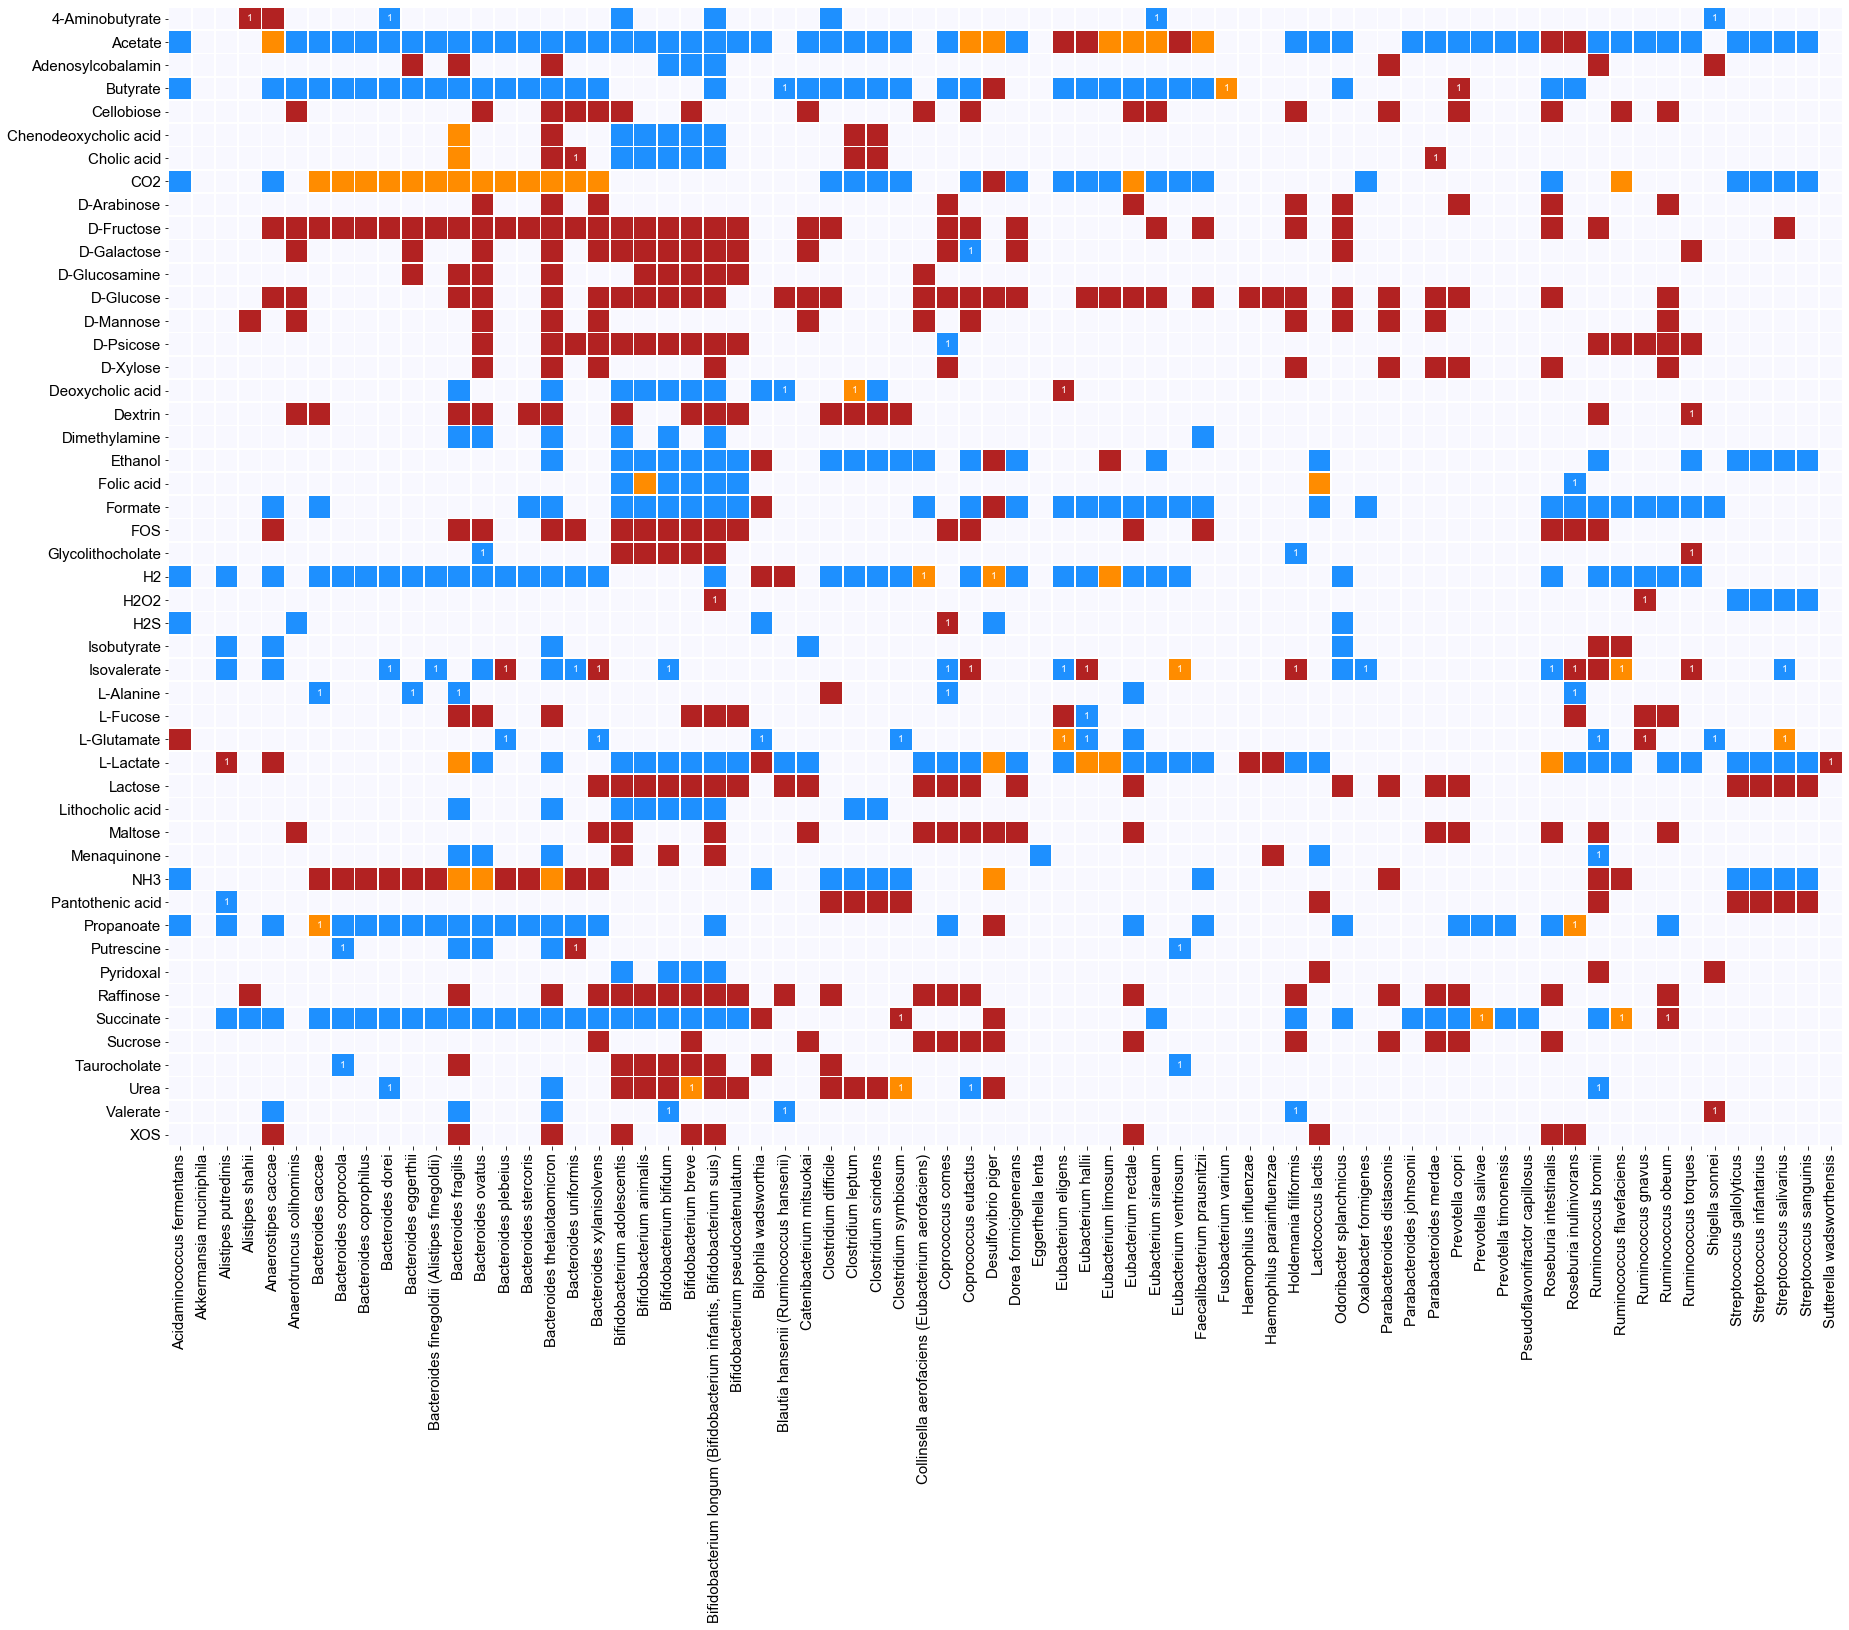

In [82]:
condition = np.sum(df_net_newAll,1) >= 10

show_annot_array = (net_label[condition] > 0)
fig, ax = plt.subplots(1,1,figsize=(30, 30))
sns.heatmap(df_net_newAll[condition], ax = ax, center=2, cmap=cmap, linewidths=0.75, annot=net_label[condition], square=True, cbar=False,
           xticklabels = True, yticklabels = True)
for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
    text.set_visible(show_annot)

### Some examples of how the addition of links helps to remove the bias of predictions
* Direct effects: 
    * **Spermidine**: 1 consumption link solves the over-prediction.
    * **Urea**: 2 consumption links + 4 production links added to fix the problem of underprediction.
    * **Isovalerate**: 4 consumption links + 6 production links added to fix the problem of underprediction. It maybe add the consumption links to prevent overshooting.
    * **Putrescine**: 3 consumption links added solve the problem of over-prediction.
    * **L-Lysine**: previously no production links added in Chia. 1 production link is added.
* Indirect effects: 
    * **5-Aminovalerate**: no links added. However, the question of underpredicted is still solved because of the cascade.
* Surprise: 
    * **Deoxycholic acid**: 2 production links added can solve the overprediction problem.

## Create a dataframe with all bias information included

In [120]:
bias_chia = np.zeros((thai_metabolome.shape[1], thai_metabolome.shape[0]))
bias_added = np.zeros((thai_metabolome.shape[1], thai_metabolome.shape[0]))
for pa in range(thai_metabolome.shape[1]):
    s1 = thai_metabolome.iloc[:, pa].values / np.sum(thai_metabolome.iloc[:,pa].values)
    s2 = metabolome_predicted_chia[pa, :]
    s3 = metabolome_predicted[pa, :]
    bias_chia[pa, :] = np.log10(s2 + 1e-100) - np.log10(s1 + 1e-100)
    bias_added[pa, :] = np.log10(s3 + 1e-100) - np.log10(s1 + 1e-100)
    
bias = []
metaboliteID = []
ifAdded = []
whichIndividual = []

for i in range(thai_metabolome.shape[0]):
    bias_temp = bias_chia[:,i]
    i_validIndividal = np.where((bias_temp > -90) & (bias_temp < 90) & (bias_temp!=0))[0]
    whichIndividual = whichIndividual + list(i_validIndividal)
    bias = bias + list(bias_temp[i_validIndividal])
    metaboliteID = metaboliteID + [i] * i_validIndividal.shape[0]
ifAdded = ifAdded + [0] * len(metaboliteID)
prevLen = len(metaboliteID)

for i in range(thai_metabolome.shape[0]):
    bias_temp = bias_added[:,i]
    i_validIndividal = np.where((bias_temp > -90) & (bias_temp < 90) & (bias_temp!=0))[0]
    whichIndividual = whichIndividual + list(i_validIndividal)
    bias = bias + list(bias_temp[i_validIndividal])
    metaboliteID = metaboliteID + [i] * i_validIndividal.shape[0]
ifAdded = ifAdded + [1] * (len(metaboliteID) - prevLen)

data = {'bias': bias, 'metaboliteID':metaboliteID, 'ifAdded':ifAdded, 'whichIndividual':whichIndividual}
df_metabolomeBias = pd.DataFrame.from_dict(data)

## Visualize the bias of metabolites using seaborn

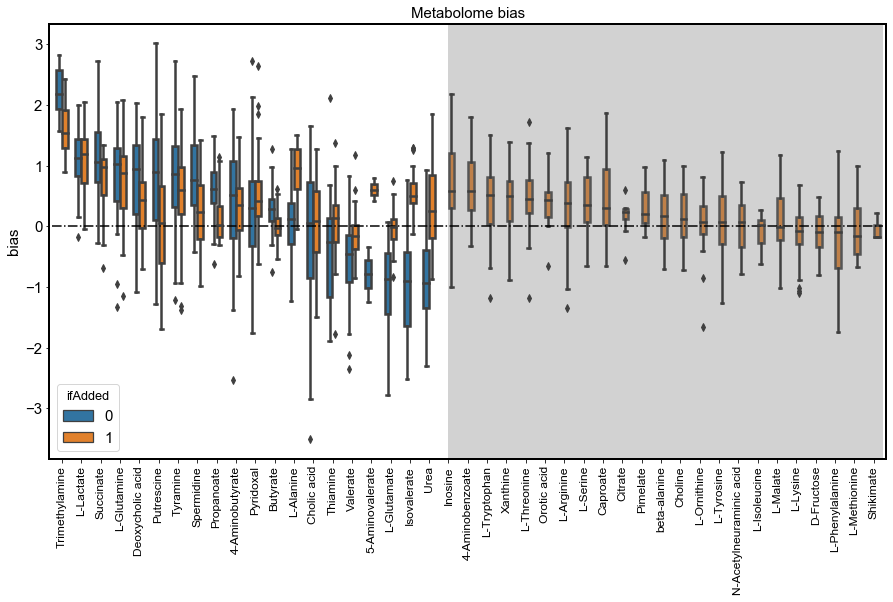

In [122]:
medianBias = df_metabolomeBias[['metaboliteID', 'ifAdded', 'bias']].groupby(['metaboliteID', 'ifAdded']).median()#.apply(np.median)
medianBias = medianBias.reset_index().set_index('metaboliteID')
uniqueIDs = np.unique(medianBias.index)
bias_reduction = []
for id in uniqueIDs:
    if len(medianBias.loc[[id]]) > 1:
        ori_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==0].values[0,1]
        added_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==1].values[0,1]
        #bias_reduction.append((added_error - ori_error) * np.sign(ori_error))
        #bias_reduction.append(np.abs(ori_error))
        bias_reduction.append(ori_error)
    else:
        added_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==1].values[0,1]
        bias_reduction.append(added_error-50)
orderedIDs = uniqueIDs[np.argsort(bias_reduction)[::-1]]
commonMetName = df_metabolites.reset_index().set_index('newID').loc[thai_metabolome_ID[uniqueIDs]].values.flatten()
commonMetName = names.loc[commonMetName[np.argsort(bias_reduction)[::-1]]]

fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(x="metaboliteID", y="bias", hue="ifAdded", data=df_metabolomeBias, 
            linewidth=2.5, width=0.6, ax=ax, order=orderedIDs )
x_axis_len = uniqueIDs.shape[0]
ax.set_xticks(range(x_axis_len))
shorted_metNames = list(map(lambda x: x.split(' (')[0] ,list(commonMetName.values.flatten())))
ax.set_xticklabels(shorted_metNames, rotation='vertical', size=12)
ax.set_xlabel('')
plt.plot([-0.5, x_axis_len-0.5],[0,0],'k-.');
plt.axvspan(np.sum(np.array(bias_reduction) > -40), uniqueIDs.shape[0]-0.5, facecolor='0.5', alpha=0.35);
plt.title('Metabolome bias')
#fig.savefig('./figures/fig3E.svg')
#plt.savefig('./Metabolome_bias.svg')
#plt.savefig('./Metabolome_bias.eps')


## MAMBO test

In [168]:
NUMADDED = len(net_new) - len(net_ori)

df_added_metabolites = names.loc[df_metabolites.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,0]].values.flatten()]
df_added_metabolites.reset_index(inplace=True)
df_added_metabolites.columns = ['metabolite ID', 'metabolite names'] 

df_added_microbes = names.loc[df_microbes.reset_index().set_index('newID').loc[net_new.iloc[-NUMADDED:,1]].values.flatten()]
df_added_microbes.reset_index(inplace=True)
df_added_microbes.columns = ['microbes ID', 'microbes names'] 

df_added_edgeTypes = net_new.iloc[-NUMADDED:,2]
df_added_edgeTypes = pd.DataFrame(df_added_edgeTypes)
df_added_edgeTypes.index = range(NUMADDED)

df_added_tables = pd.concat([df_added_metabolites, df_added_microbes, df_added_edgeTypes], axis=1, sort=False)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


6775 30749
0.22033236853231
81
48
P-value is 0.0004486575578480645


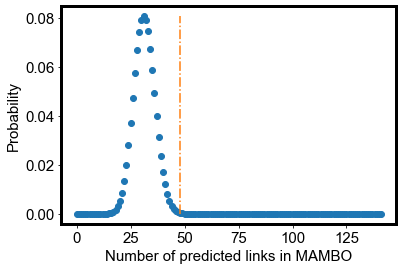

In [171]:
NUMADDED = df_added_tables.shape[0]

max_links = MAX_ID_metabolites * MAX_ID_microbes
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("../mambo_curated.txt", sep = '\t')
df_MAMBO_temp = df_MAMBO.copy()
df_MAMBO['edge_type'][df_MAMBO['edge_type']==5] = 2
df_MAMBO_temp['edge_type'][df_MAMBO_temp['edge_type']==5] = 3
df_MAMBO = df_MAMBO.append(df_MAMBO_temp).drop_duplicates()

df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['metabolite_ID', 'microbe_ID', 'edge_type']].copy()
df_MAMBO_filtered_newID.columns = net.columns
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values

s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(df_MAMBO_filtered_newID, net))

#max_size = np.unique(df_MAMBO_filtered['metabolite_ID']).shape[0] * np.unique(df_MAMBO_filtered['microbe_ID']).shape[0]

print((len(df_MAMBO_filtered) - numOverlap), (2*max_links - len(net_ori)))
print((len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1 and 
       np.sum((df_MAMBO['edge_type'] == df_added_tables['edgeType'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]) & 
         (df_MAMBO['edge_type'] == df_added_tables['edgeType'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
#typeCounts = Counter(df_MAMBO_filtered['edge_type'])
#p = (typeCounts[2] + typeCounts[3] + 2 * typeCounts[5] - numOverlap) / (2*max_links - len(net_ori))
p = (len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori))
#p = (203 + 3589 * 2) / (2*max_links)
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))


31.28719633158802 4.938989194067328 48


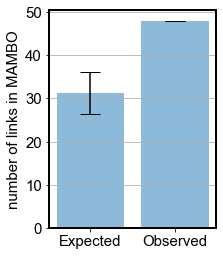

In [193]:
nullExpectation = NUMADDED * p
std = np.sqrt(NUMADDED * p * (1 - p))
addedLinkCoverage = k
print(nullExpectation, std, addedLinkCoverage)

x_pos = np.arange(2)
CTEs = [nullExpectation, addedLinkCoverage]
error = [std, 0]

fig, ax = plt.subplots(figsize=(3,4))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('number of links in MAMBO')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Expected', 'Observed'])
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
fig.savefig('./figures/figure4B.svg')


## Visualize the bias of microbes using seaborn

Text(0.5, 1.0, 'Metagenome bias')

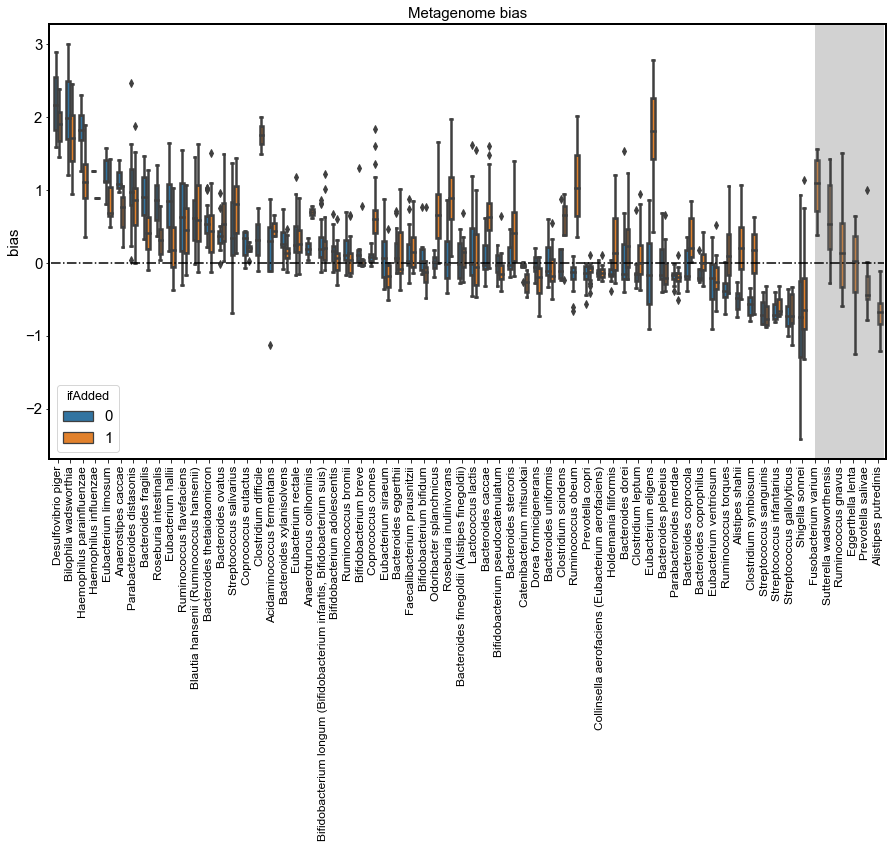

In [143]:
bias_chia = np.zeros((thai_metagenome.shape[1], thai_metagenome.shape[0]))
bias_added = np.zeros((thai_metagenome.shape[1], thai_metagenome.shape[0]))
for pa in range(thai_metagenome.shape[1]):
    s1 = thai_metagenome.iloc[:, pa].values / np.sum(thai_metagenome.iloc[:,pa].values)
    s2 = metagenome_predicted_chia[pa, :]
    s3 = metagenome_predicted[pa, :]
    bias_chia[pa, :] = np.log10(s2 + 1e-100) - np.log10(s1 + 1e-100)
    bias_added[pa, :] = np.log10(s3 + 1e-100) - np.log10(s1 + 1e-100)
    
bias = []
metaboliteID = []
ifAdded = []
whichIndividual = []

for i in range(thai_metagenome.shape[0]):
    bias_temp = bias_chia[:,i]
    i_validIndividal = np.where((bias_temp > -90) & (bias_temp < 90) & (bias_temp!=0))[0]
    whichIndividual = whichIndividual + list(i_validIndividal)
    bias = bias + list(bias_temp[i_validIndividal])
    metaboliteID = metaboliteID + [i] * i_validIndividal.shape[0]
ifAdded = ifAdded + [0] * len(metaboliteID)
prevLen = len(metaboliteID)

for i in range(thai_metagenome.shape[0]):
    bias_temp = bias_added[:,i]
    i_validIndividal = np.where((bias_temp > -90) & (bias_temp < 90) & (bias_temp!=0))[0]
    whichIndividual = whichIndividual + list(i_validIndividal)
    bias = bias + list(bias_temp[i_validIndividal])
    metaboliteID = metaboliteID + [i] * i_validIndividal.shape[0]
ifAdded = ifAdded + [1] * (len(metaboliteID) - prevLen)

data = {'bias': bias, 'metaboliteID':metaboliteID, 'ifAdded':ifAdded, 'whichIndividual':whichIndividual}
df_metagenomeBias = pd.DataFrame.from_dict(data)

import seaborn
medianBias = df_metagenomeBias[['metaboliteID', 'ifAdded', 'bias']].groupby(['metaboliteID', 'ifAdded']).median()#.apply(np.median)
medianBias = medianBias.reset_index().set_index('metaboliteID')
uniqueIDs = np.unique(medianBias.index)
bias_reduction = []
for id in uniqueIDs:
    if len(medianBias.loc[[id]]) > 1:
        ori_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==0].values[0,1]
        added_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==1].values[0,1]
        #bias_reduction.append((added_error - ori_error) * np.sign(ori_error))
        #bias_reduction.append(np.abs(ori_error))
        bias_reduction.append(ori_error)
    else:
        added_error = medianBias.loc[[id]][medianBias.loc[[id]]['ifAdded']==1].values[0,1]
        bias_reduction.append(added_error-50)
orderedIDs = uniqueIDs[np.argsort(bias_reduction)[::-1]]
commonMetName = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID[uniqueIDs]].values.flatten()
commonMetName = names.loc[commonMetName[np.argsort(bias_reduction)[::-1]]]

fig, ax = plt.subplots(1,1, figsize=(15, 8))
sns.boxplot(x="metaboliteID", y="bias", hue="ifAdded", data=df_metagenomeBias, 
            linewidth=2.5, width=0.6, ax=ax, order=orderedIDs )
x_axis_len = uniqueIDs.shape[0]
ax.set_xticks(range(x_axis_len))
ax.set_xticklabels(list(commonMetName.values.flatten()), rotation='vertical', size=12)
ax.set_xlabel('')
plt.plot([-0.5, x_axis_len-0.5],[0,0],'k-.');
plt.axvspan(np.sum(np.array(bias_reduction) > -40), uniqueIDs.shape[0]-0.5, facecolor='0.5', alpha=0.35);
plt.title('Metagenome bias')

## Check the correlation between the bias of metabolites and the number of links added releted to it

(0.15241591747307048, 0.24499962669913591)

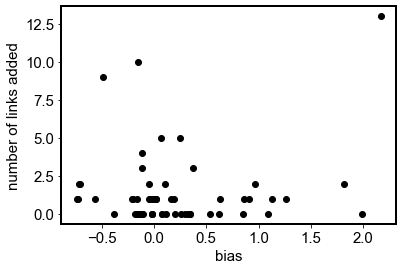

In [174]:
bias_chia_median = medianBias[medianBias['ifAdded']==0]
i_met_chiaID = np.array(list(bias_chia_median.index))
bias_chia_median = bias_chia_median.values[:,1]
i_met_newID = thai_metabolome_ID[i_met_chiaID]
i_met_chiaID = df_metabolites.reset_index().set_index('newID').loc[i_met_newID].values.flatten()
nameMet_chia = names.loc[i_met_chiaID]

numLinksAddedForOneMetabolite = []
for oneMetID in i_met_newID:
    numLinksAddedForOneMetabolite.append(len(net_added[net_added['metabolites']==oneMetID]))
plt.figure()
plt.plot(bias_chia_median, numLinksAddedForOneMetabolite, 'ko')
plt.xlabel('bias')
plt.ylabel('number of links added')
plt.savefig('./figures/fig_S1.svg')
pearsonr(bias_chia_median, numLinksAddedForOneMetabolite)


## Check the correlation between the prior prob of metabolites and error reduced

(0.028105934884800513, 0.7425815059859899)

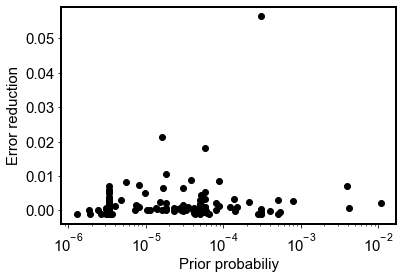

In [173]:
#df[netNUM]
######## Select all microbes in the Thai data:
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = 0.05

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)

#m2b_ori = (m2b[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
#b2m_ori = (b2m[np.ix_(thai_metabolome_ID,thai_metagenome_ID)]!=0).astype(int).copy()
m2b_ori = (m2b!=0).astype(int).copy()
b2m_ori = (b2m!=0).astype(int).copy()
x_ori = np.concatenate([m2b_ori.flatten(), b2m_ori.flatten()])
net_ori = net.copy()

def pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori):
    '''
    pred_error_addingLinks is a function used to compute the logarithmic error between experimentally measured
    metagenome and predicted metagenome computed from the model for a certain nutrient intake. It relies on 
    (1) x: the nutrient intake, (2) i_intake: IDs of the nutrient intake, (3) m2b_total: a conversion matrix 
    from thenutrient intake to the total biomass, and (4) b_real: experimentally measured metagenome. The 
    first three is used to compute the metagenome predicted by the model "ba_pred" and compare it with the 
    experimentally measured metagenome "b_real".
    '''
    max_links = m2b_ori.shape[0] * m2b_ori.shape[1]
    
    ######## Convert x to net structure:
    thres = 0.1
    x = x - x_ori
    m2b_added = x[:max_links].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    #a = thai_metabolome_ID.iloc[np.where(m2b_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(m2b_added >= thres)[1]]
    #a = thai_metabolome_ID[np.where(m2b_added >= thres)[0]]
    a = df_metabolites['newID'].values[np.where(m2b_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(m2b_added >= thres)[1]]
    c = [2] * np.where(m2b_added >= thres)[1].shape[0]
    net_added_consumption = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})

    b2m_added = x[max_links:].reshape((m2b_ori.shape[0], m2b_ori.shape[1]))
    #a = thai_metabolome_ID.iloc[np.where(b2m_added >= thres)[0]]
    #b = thai_metagenome_ID.iloc[np.where(b2m_added >= thres)[1]]
    #a = thai_metabolome_ID[np.where(b2m_added >= thres)[0]]
    a = df_metabolites['newID'].values[np.where(b2m_added >= thres)[0]]
    b = thai_metagenome_ID[np.where(b2m_added >= thres)[1]]
    c = [3] * np.where(b2m_added >= thres)[1].shape[0]
    net_added_production = pd.DataFrame({net_ori.columns[0]:list(a), net_ori.columns[1]:list(b), net_ori.columns[2]:c})
    
    net = pd.concat([net_ori, net_added_consumption, net_added_production])
    
    f_byproduct = 0.9
    f = f_byproduct * np.ones((MAX_ID_microbes,1));
    f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

    numLevels_max = 4

    corr_list_aveDiet = np.zeros((41,2))
    log_list_aveDiet = np.zeros((41,2))
    order_dev_list = np.zeros((41, MAX_ID_metabolites))
    order_dev_metagenome_list = np.zeros((41, MAX_ID_microbes))
    numMetabolites_list = np.zeros((41))
    for pa in range(41):
        #print(pa)
        ######## Select an ID of a individual and pull out its experimentally measured metagenome:
        b_real = np.zeros((MAX_ID_microbes,))
        b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

        ######## Compute matrices involving the metabolite consumption and generation:
        m2b, b2m = Ain_out(b_real, net)
        #m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
        m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        #x_full = np.zeros((MAX_ID_metabolites,));
        #x_full[i_intake] = average_diet.copy();
        #ba_pred = np.dot(m2b_total, x_full)
        
        ######## Assign diet
        x0 = np.ones((len(i_intake),)) / len(i_intake)

        ######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
        # minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
        # from the model for a certain nutrient intake.
        fun2 = lambda y: pred_error(y, b_real, m2b_total, i_intake)
        bnds = ((0, 100), ) * len(x0)
        res = minimize(fun2, x0, method='SLSQP', bounds=bnds, options={'disp': False, 'maxiter': 1000}, tol=1e-3, callback=None)
        #res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
        #res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
        #print(res)

        ######## As long as the optimized nutrient intake is found by using the above optimization solver, the
        # optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
        # visually and statistically compared to the experimentally measured metagenome and metabolome.
        x_full = np.zeros((MAX_ID_metabolites,));
        x_full[i_intake] = res.x;
        ba_pred = np.dot(m2b_total, x_full)

        #met_levels, met_leftover_levels = calc_metabolome(average_diet.copy(), m2m_layer, numLevels_max, i_intake)
        met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
        metabolome_measured = np.zeros((MAX_ID_metabolites,))
        metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
        metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
        i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
        metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
        metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])
        ######## compute the bias of the order of magnitude
        order_dev_metagenome_list[pa, :] = np.log10(b_real + 1e-5) - np.log10(ba_pred + 1e-5)
        order_dev_list[pa, i_common] = np.log10(metabolome_measured_common + 1e-5) - np.log10(metabolome_pred_common + 1e-5)
        numMetabolites_list[pa] = i_common.shape[0]

        corr_list_aveDiet[pa, 0] = pearsonr(ba_pred[b_real>0], b_real[b_real>0])[0]
        corr_list_aveDiet[pa, 1] = pearsonr(metabolome_pred_common, metabolome_measured_common)[0]
        log_list_aveDiet[pa, 0] = np.mean(np.abs(np.log10(ba_pred[b_real>0]+1e-6) - np.log10(b_real[b_real>0]+1e-6)))
        log_list_aveDiet[pa, 1] = np.mean(np.abs(np.log10(metabolome_pred_common+1e-6) - np.log10(metabolome_measured_common+1e-6)))
        '''
        print('-------------------------------------------------------------------------------------------------------------')
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
        print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
        print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
        print(pearsonr(metabolome_pred_common, metabolome_measured_common))
        '''  
        
    x_full = np.zeros((MAX_ID_metabolites,));
    x_full[i_intake] = res.x;
    
    ba_pred = np.dot(m2b_total, x_full)
    #pred_error1 = (np.log10(ba_pred + 1e-6) - np.log10(b_real +1e-6)) / np.log10(b_real +1e-6);
    #pred_error2 = (np.log10(metabolome_pred_common + 1e-6) - np.log10(metabolome_measured_common + 1e-6)) / np.log10(metabolome_measured_common + 1e-6);
    #pred_error1 = np.mean(corr_list_aveDiet[:,0])
    #pred_error2 = np.mean(corr_list_aveDiet[:,1])
    #pred_error3 = np.sum(np.abs(x))
    #hyper_reg = 0.01
    #pred_error = 1 - pred_error1 + 1 - pred_error2 + hyper_reg * pred_error3
    
    pred_error1 = np.mean(log_list_aveDiet[:,0])
    pred_error2 = np.mean(log_list_aveDiet[:,1])
    pred_error3 = np.sum(np.abs(x))
    pred_error4 = np.mean(numMetabolites_list)
    hyper_reg = 0.001
    #pred_errorTotal = pred_error1 + pred_error2 + hyper_reg * pred_error3
    #pred_errorTotal = pred_error2 + hyper_reg * pred_error3
    pred_errorTotal = pred_error2 + hyper_reg * pred_error3 - (pred_error4 - 20) * 0.003 # with reward
    #print(pred_error, pred_error3)
    
    return [pred_errorTotal, np.abs(np.sum(order_dev_list, 0)), np.sum(order_dev_metagenome_list, 0)]
    #return [pred_errorTotal, np.abs(np.sum(order_dev_list, 0)), np.abs(np.sum(order_dev_metagenome_list, 0))]

fun = lambda x: pred_error_addingLinks(x, m2b_ori, b2m_ori, x_ori)
max_links = m2b.shape[0]*m2b.shape[1]
x = x_ori.copy()
#nonChia = np.where(x_ori==0)[0]
error_before, bias_metabolome, bias_metagenome = fun(x)
bias_metabolome_ori = bias_metabolome.copy()
prior_prob1 = np.matlib.repmat(np.exp(3 * (bias_metagenome) / 41)[np.newaxis, :], m2b.shape[0], 1) * np.matlib.repmat(np.exp(3 * bias_metabolome_ori / 41)[:, np.newaxis], 1, m2b.shape[1])
prior_prob2 = np.matlib.repmat(np.exp(3 * bias_metabolome_ori / 41)[:, np.newaxis], 1, m2b.shape[1])
prior_prob = np.concatenate([prior_prob1.flatten(), prior_prob2.flatten()]) + 0.1
prior_prob = prior_prob / np.sum(prior_prob)

prior_prob_ofAddedLinks = prior_prob[df[netNUM]['position in x'].values]
error_reduced_ofAddedLinks = df[netNUM]['error reduced'].values
plt.plot(prior_prob_ofAddedLinks, error_reduced_ofAddedLinks, 'ko')
plt.xscale('log')
plt.xlabel('Prior probabiliy')
plt.ylabel('Error reduction')
plt.savefig('./figures/fig_S2.svg')
pearsonr(prior_prob_ofAddedLinks, error_reduced_ofAddedLinks)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.2986932508967106
            Iterations: 14
            Function evaluations: 310
            Gradient evaluations: 14
     fun: 3.2986932508967106
     jac: array([ 0.        , -0.00607041,  0.00249973,  0.00244379,  0.01342097,
        0.01750383,  0.01855433,  0.00281239,  0.00334352,  0.01648417,
       -0.00632995,  0.00306493,  0.02916449,  0.05973503, -0.00965661,
        0.0092881 ,  0.1019651 ,  0.00812569,  0.00533977,  0.02321699])
 message: 'Optimization terminated successfully.'
    nfev: 310
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([5.00000000e-02, 2.88444573e-03, 1.21632546e+00, 9.06181188e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36143685e-02, 0.00000000e+00, 1.45227455e-01, 1.21038497e+00,
       2.98634689e-17, 3.27114524e-17, 8.90697495e-01, 5.52302836e-01,
       4.27068948e-18, 1.59140976e-02, 5.64292766

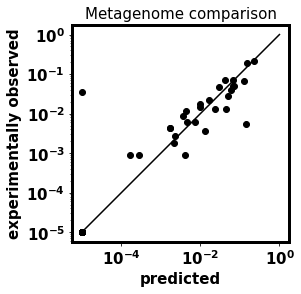

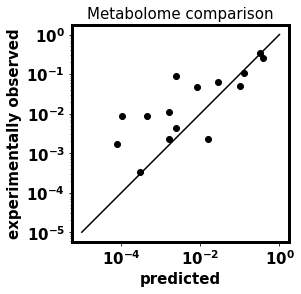

In [518]:
f_byproduct = 0.9
f = f_byproduct * np.ones((MAX_ID_microbes,1));
f[i_selfish] = 0.0;  # The byproduct/leakage fraction f for microbes that don't generate byproducts is set as 0.

numLevels_max = 4

######## Select an ID of a individual and pull out its experimentally measured metagenome:
pa = 3; 
b_real = np.zeros((MAX_ID_microbes,))
b_real[thai_metagenome_ID] = thai_metagenome.iloc[:,pa] / np.sum(thai_metagenome.iloc[:,pa])

######## Compute matrices involving the metabolite consumption and generation:
m2b, b2m = Ain_out(b_real, net)
m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(f, m2b, b2m, numLevels_max)
#m2b_total, m2m_total, m2m_layer = m2b_multiple_levels(i_nonzero_microbes, i_nonzero_metabolites, f, m2b, b2m, numLevels_max)

######## Assign diet
x0 = np.ones((len(i_intake),)) / len(i_intake)

######## The model is converted into an optimization problem where the nutrient intake is constantly changed to
# minimize the logarithmic error between experimentally measured metagenome and predicted metagenome computed 
# from the model for a certain nutrient intake.
fun = lambda x: pred_error(x, b_real, m2b_total, i_intake)
bnds = ((0, 100), ) * len(x0)
res = minimize(fun, x0, method='SLSQP', bounds=bnds, options={'disp': True, 'maxiter': 1000}, tol=1e-3)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, options={'disp': True})
#res = minimize(fun, x0, method='TNC', bounds=bnds, options={'disp': True, 'maxiter': 1000})
print(res)

######## As long as the optimized nutrient intake is found by using the above optimization solver, the
# optimized nutrient intake "res.x" is used to generate the predict metagenome and metabolome. They are
# visually and statistically compared to the experimentally measured metagenome and metabolome.
x_full = np.zeros((MAX_ID_metabolites,));
x_full[i_intake] = res.x;
ba_pred = np.dot(m2b_total, x_full)

#### Metagenome comparison
fig, ax = plt.subplots()
ax.loglog(ba_pred+1e-5, b_real+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metagenome comparison')

met_levels, met_leftover_levels = calc_metabolome(res.x, m2m_layer, numLevels_max, i_intake)
metabolome_measured = np.zeros((MAX_ID_metabolites,))
#metabolome_measured[thai_metabolome_ID.values] = thai_metabolome.iloc[:,pa]
metabolome_measured[thai_metabolome_ID] = thai_metabolome.iloc[:,pa]
metabolome_pred = met_levels[:, -1] + met_leftover_levels.sum(1) #np.dot(m2m_total, x_full)
#metabolome_pred = np.dot(m2m_total, x_full)
i_common = np.where(metabolome_measured * metabolome_pred > 1e-5)[0]
metabolome_pred_common = metabolome_pred[i_common] / np.sum(metabolome_pred[i_common])
metabolome_measured_common = metabolome_measured[i_common] / np.sum(metabolome_measured[i_common])

#### Metabolome comparison
fig, ax = plt.subplots()
ax.loglog(metabolome_pred_common+1e-5, metabolome_measured_common+1e-5, 'ko')
ax.plot([1e-5, 1], [1e-5, 1],'k-')
ax.set_aspect('equal')
ax.set_xlabel('predicted')
ax.set_ylabel('experimentally observed')
ax.set_title('Metabolome comparison')

print('-------------------------------------------------------------------------------------------------------------')
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metagonome:')
print(pearsonr(ba_pred[b_real>0], b_real[b_real>0]))
print('(Correlation coefficient, P-value) of the correlation between predicted and experimentally measured metabolome:')
#print(pearsonr(metabolome_pred_common, metabolome_measured_common))
print(pearsonr(np.log10(metabolome_pred_common+1e-5), np.log10(metabolome_measured_common+1e-5)))
print(i_common.shape[0])


In [ ]:
NUMADDED = df_prevalence.shape[0]

max_links = MAX_ID_metabolites * MAX_ID_microbes
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("../mambo_curated.txt", sep = '\t')
df_MAMBO_temp = df_MAMBO.copy()
df_MAMBO['edge_type'][df_MAMBO['edge_type']==5] = 2
df_MAMBO_temp['edge_type'][df_MAMBO_temp['edge_type']==5] = 3
df_MAMBO = df_MAMBO.append(df_MAMBO_temp).drop_duplicates()

df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['metabolite_ID', 'microbe_ID', 'edge_type']].copy()
df_MAMBO_filtered_newID.columns = net.columns
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values

s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(df_MAMBO_filtered_newID, net))

#max_size = np.unique(df_MAMBO_filtered['metabolite_ID']).shape[0] * np.unique(df_MAMBO_filtered['microbe_ID']).shape[0]

print((len(df_MAMBO_filtered) - numOverlap), (2*max_links - len(net_ori)))
print((len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_prevalence['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_prevalence['metabolite ID'].iloc[i]))>=1 and 
       np.sum((df_MAMBO['edge_type'] == df_prevalence['edgeType'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_prevalence['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_prevalence['metabolite ID'].iloc[i]) & 
         (df_MAMBO['edge_type'] == df_prevalence['edgeType'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
#typeCounts = Counter(df_MAMBO_filtered['edge_type'])
#p = (typeCounts[2] + typeCounts[3] + 2 * typeCounts[5] - numOverlap) / (2*max_links - len(net_ori))
p = (len(df_MAMBO_filtered) - numOverlap) / (2*max_links - len(net_ori))
#p = (203 + 3589 * 2) / (2*max_links)
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))


In [161]:
max_links = MAX_ID_metabolites * MAX_ID_microbes
chia_microbes_in_Thai = df_microbes.reset_index().set_index('newID').loc[thai_metagenome_ID].values.flatten()
chia_metabolites_in_Thai = df_metabolites.reset_index().set_index('newID').loc[df_metabolites['newID']].values.flatten()

df_MAMBO = pd.read_csv("../mambo_curated.txt", sep = '\t')
df_MAMBO_filtered = df_MAMBO[df_MAMBO['microbe_ID'].apply(lambda x: x in chia_microbes_in_Thai)]
df_MAMBO_filtered = df_MAMBO_filtered[df_MAMBO_filtered['metabolite_ID'].apply(lambda x: x in chia_metabolites_in_Thai)]

df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))

print((len(df_MAMBO_filtered)-numOverlap), (2*max_links - len(net_ori)))
print((len(df_MAMBO_filtered)-numOverlap) / (2*max_links - len(net_ori)) )

k = 0
l = 0
ifIncluded = np.zeros((NUMADDED))
ifCovered = np.zeros((NUMADDED))
for i in range(NUMADDED):
    if (np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i])) >=1 and 
       np.sum((df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1):
        ifCovered[i] = 1
        l += 1
    if np.sum((df_MAMBO['microbe_ID'] == df_added_tables['microbes ID'].iloc[i]) & 
       (df_MAMBO['metabolite_ID'] == df_added_tables['metabolite ID'].iloc[i]))>=1:
        ifIncluded[i] = 1
        k += 1
print(l)
print(k)

from scipy.stats import bernoulli, binom
xx = range(NUMADDED)
p = len(df_MAMBO_filtered) / (2*max_links)
#p = (203 + 3589 * 2) / (2*max_links)
#prob = bernoulli.cdf(xx, p)
probCum = binom.cdf(xx, NUMADDED, p)
prob = binom.pmf(xx, NUMADDED, p)
plt.plot(xx, prob, 'o')
plt.plot([k, k], [0, np.max(prob)], '-.')
plt.xlabel('Number of predicted links in MAMBO')
plt.ylabel('Probability')
p_value = 1 - probCum[k]
print('P-value is',str(p_value))


3217 30749
0.1046212884971869


IndexError: single positional indexer is out-of-bounds

In [58]:
len(df_MAMBO_filtered)
from collections import Counter
Counter(df_MAMBO_filtered['edge_type'].values)

203 + 3589 * 2

Counter({5: 3589, 2: 203})

In [47]:
df_all.sort_values(['metabolite ID', 'microbes ID'])

#pd.unique(df_all)
df_all[['metabolite ID', 'microbes ID', 'edgeType', 'position in x']].drop_duplicates()

,metabolite ID,microbes ID,edgeType,position in x
0,2212,457,2,13793
1,2217,124,2,14050
2,2081,309,2,5212
3,2238,457,3,31433
4,2081,131,2,5198
5,2233,513,2,15167
6,2240,969,2,15689
7,2106,9,3,22680
8,2238,870,3,31447
9,2240,124,3,31546


In [100]:
pos_sig = list(prevOfLinksSorted.keys())[:numOfSigLinks]
#list(prevOfLinksSorted.values())[:numOfSigLinks]
pos_sig

[18458,
 28911,
 25433,
 27017,
 28898,
 31601,
 23685,
 24909,
 23785,
 24345,
 28897,
 16648,
 24405,
 31545,
 31590,
 24361,
 20101,
 24375,
 23920,
 24089,
 24521,
 20122,
 24087,
 31380,
 28240,
 23655,
 25053,
 31595,
 25145,
 24353,
 25693,
 23675,
 27754,
 23677,
 23799,
 24380,
 31605,
 27012,
 18013,
 30828,
 19091,
 23820,
 24092,
 24492,
 23657,
 23772,
 18501,
 25864,
 24497,
 24996,
 25081,
 31480,
 24346,
 26033,
 28241,
 25788,
 19609,
 23676,
 30829,
 31482,
 25082,
 16653,
 15153,
 20373,
 18467,
 25882,
 23999,
 24565,
 31551,
 27501,
 25097,
 25168,
 24667,
 31569,
 5729,
 16550,
 6879,
 24568,
 26344,
 31575,
 24109,
 18457,
 16645,
 27493,
 16579,
 24397,
 31621,
 31542,
 22651,
 5982,
 24524,
 24396,
 24386,
 17318,
 24635,
 25886,
 25138,
 23786,
 24541,
 24351,
 28766,
 23654,
 16506,
 29656,
 23622,
 19083,
 23200,
 25861,
 30756,
 23642,
 31333,
 31553,
 26291,
 31561,
 15194,
 26180,
 23625,
 16581,
 25287,
 24362,
 5244,
 23218,
 25981,
 2534,
 18038,
 2523

In [101]:
df_all = df[0].copy()
for i in range(1, 100):
    df_all = pd.concat([df_all, df[i]])
df_all.set_index('position in x', inplace=True)
df_all.loc[pos_sig]

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,error reduced,step added
position in x,,,,,,,
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000193,2191
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.003172,575
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.001280,3227
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000765,2593
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.004593,1670
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.003017,823
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.000970,3070
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,0.002122,818
18458,2038,161,Butyrate,Blautia hansenii (Ruminococcus hansenii),3,-0.000208,5529


In [110]:
ys_actual, xs_actual = np.histogram(list(prevOfLinksSorted.values()), bins=5, normed=True)
print(xs_actual, ys_actual)

[ 1.   4.6  8.2 11.8 15.4 19. ] [0.24300303 0.02742057 0.00556816 0.00136578 0.00042024]


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


In [139]:
numOfSigLinks = np.sum(np.array(list(prevOfLinksSorted.values())) >= threshold)
numOfTotalLinks = np.array(list(prevOfLinksSorted.values())).shape[0]
print(numOfSigLinks, numOfTotalLinks)
print(numOfSigLinks / numOfTotalLinks)

511 2644
0.193267776096823


In [ ]:



df_MAMBO = pd.read_csv("mambo_curated.txt", sep = '\t')
df_MAMBO_filtered_newID = df_MAMBO_filtered[['microbe_ID', 'metabolite_ID']].copy()
df_MAMBO_filtered_newID.columns = ['microbes', 'metabolites']
df_MAMBO_filtered_newID['microbes'] = df_microbes.loc[df_MAMBO_filtered_newID['microbes']].values
df_MAMBO_filtered_newID['metabolites'] = df_metabolites.loc[df_MAMBO_filtered_newID['metabolites']].values
s1 = df_MAMBO_filtered_newID
s2 = net[['metabolites', 'microbes']]
numOverlap = len(pd.merge(s1, s2, how='inner'))